# MVP model fine-tune analysis using mixed windows for guessing the validation test

In [12]:
# Input parameters
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [13]:
#! pip install --no-deps ydata_profiling
#! pip install --no-deps dacite
#! pip install --no-deps multimethod
#! pip install --no-deps visions
#! pip install --no-deps wordcloud
#! pip install --no-deps imagehash
#! pip install --no-deps htmlmin
#! pip install evaluate
#!pip install tslearn

In [14]:
import torch
torch.cuda.set_device(0)
#torch.cuda.set_device(1)

In [15]:
# Imports
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut
from dvats.imports import beep
import pandas as pdz
from copy import deepcopy
import matplotlib.pyplot as plt
import ydata_profiling as ydp
import seaborn as sns

In [16]:
# User and project
entity = os.environ.get("WANDB_ENTITY")
project = os.environ.get("WANDB_PROJECT")
folder = entity+'/'+project+'/'

# Dataset
dataset = 'gtrends_kohls'
dataset_version = 'v2'

#dataset = 'S1'
#dataset_version = 'v8'

enc_artifact_dataset = folder + dataset + ':' + dataset_version

enc_artifact_name = "mvp:v194"

In [17]:
print("Getting dataset artifact: ", enc_artifact_dataset)
df_artifact = wandb_api.artifact(enc_artifact_dataset, type = 'dataset')

Getting dataset artifact:  mi-santamaria/deepvats/gtrends_kohls:v2


In [18]:
print(df_artifact.name)
df = df_artifact.to_df()
display(df.head())
df.shape

gtrends_kohls:v2


wandb:   1 of 1 files downloaded.  


,volume
2004-01-01,0.010417
2004-01-08,0.010417
2004-01-15,0.010417
2004-01-22,0.000000
2004-01-29,0.000000


(440, 1)

In [19]:
enc_input = df

In [20]:
import dvats.config as cfg_
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

In [21]:
n_epochs_list     = [5, 10, 20]
dataset_percents  = [0.25, 0.5, 0.75, 1] #1 No tendría sentido porque sería como hacer lo mismo que con mvp. entrenar con todo el dataset.
masked_percents = [0.25, 0.5, 0.75]
sizes             = [1, 5]
total_cases = len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)
print(f"Total cases: {total_cases}")

Total cases: 72


In [22]:
file_results_small = 'results_mvp_1'
file_errors_small = 'errors_mvp_1'
file_errors_small = file_errors_small+dataset+version+".csv"
file_results_small = file_results_small+dataset+version+".csv"

In [23]:
from dvats.encoder import _set_enc_input

## Preparing the DataLoaders

In [24]:
from fastai.data.core import DataLoaders
from torch.utils.data import Dataset, DataLoader

In [25]:
#enc_input.batch_size

In [26]:
mssg = ut.Mssg(verbose=8)
enc_input, window_sizes = _set_enc_input(
    mssg = mssg, 
    X = df, 
    stride = 1,
    batch_size = 16,
    validation_percent = 0.3,
    training_percent = 0.7,
    window_mask_percent = 0.75,
    window_sizes = [17],
    n_window_sizes = 1,
    full_dataset = True,
    mix_windows = True,
    cpu = False
)

[8] [ --> _set_enc_input ]
[8]  [ _set_enc_input ] is none enc_input? True
[8]  [ _set_enc_input ] About to get the windows
[8] [ --> windowed_dataset ]
Initialize Windowed Dataset
[8]  [ _set_enc_input ] Train size: 308
[8]  [ _set_enc_input ] Valid size: 8
[8]  [ _set_enc_input ] X is a DataFrame, X~(440, 1) | window_sizes 1, n_window_sizes 1
[8]  [ windowed_dataset ] X is a DataFrame | Window sizes: 1
[8]  [ windowed_dataset ] Building the windows
[8] [windowed_dataset --> ]
[8]  [ _set_enc_input ] About to get the encoder input
[8] [_set_enc_input --> ]


In [27]:
for batch in enc_input.data.valid_batches():
    print(f"Shape: {batch.shape}")

Shape: torch.Size([16, 1, 17])
Shape: torch.Size([16, 1, 17])
Shape: torch.Size([16, 1, 17])
Shape: torch.Size([16, 1, 17])
Shape: torch.Size([16, 1, 17])
Shape: torch.Size([16, 1, 17])
Shape: torch.Size([16, 1, 17])
Shape: torch.Size([4, 1, 17])


In [28]:
def dl_shapes(dl):
    for i, batch in enumerate(dl):
        print(f"Batch {i+1}: {type(batch)}")
        if isinstance(batch, (list, tuple)):  # Para comprobar si es una tupla de (inputs, labels)
            print(f"  Input shape: {batch[0].shape}")
            if len(batch) > 1:
                print(f"  Target shape: {batch[1].shape}")
        else:
            print(f"  Shape: {batch.shape}")  # Si batch no es una tupla/lista
    return None

In [29]:
import torch
from torch.utils.data import Dataset

class IndexedDataset(Dataset):
    def __init__(self, batches):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 🔹 Verificar si `batches` no está vacío
        if not batches:
            raise ValueError("⚠ Error: `batches` está vacío. No se puede crear un dataset sin datos.")

        # 🔹 Convertir los batches a `cuda` o `cpu`
        self.batches = [batch.to(self.device, dtype=torch.float32) for batch in batches]

        # 🔹 Verificar el primer batch
        print(f"\n📌 IndexedDataset creado con {len(self.batches)} batches")
        for i, batch in enumerate(self.batches):
            print(f"🔹 IndexedDataset Batch {i}: Shape {batch.shape}, Device {batch.device}")


        # 🔹 Verificar si el último batch es más pequeño y eliminarlo si es necesario
        if len(self.batches) > 1 and self.batches[-1].shape[0] < self.batches[0].shape[0]:
            print("⚠ Último batch más pequeño. Eliminando para evitar errores.")
            self.batches = self.batches[:-1]

        # 🔹 Confirmar si los tensores están en CUDA
        if self.batches[0].is_cuda:
            print("✅ Los tensores están correctamente en CUDA.")
        else:
            print("❌ ERROR: Los tensores no están en CUDA.")

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        batch = self.batches[idx]

        # 🔹 Solo devolver el batch (sin `None`)
        print(f"\n📌 Batch {idx} - Shape: {batch.shape}, Dispositivo: {batch.device}")
        return batch  # 🚀 Fastai espera solo el tensor, no una tupla


In [30]:
import torch
from torch.utils.data import Dataset
import torch
from fastai.data.core import DataLoaders
from fastai.data.load import DataLoader as FastaiDataLoader

class FlattenedDataset(Dataset):
    def __init__(self, batches, avoid_small = False):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if not batches:
            raise ValueError("⚠ Error: `batches` está vacío. No se puede crear un dataset sin datos.")

        self.batches = [batch.to(self.device, dtype=torch.float32) for batch in batches]

        if avoid_small and (len(self.batches) > 1 and self.batches[-1].shape[0] < self.batches[0].shape[0]):
            print("⚠ Último batch más pequeño. Eliminando para evitar errores.")
            self.batches = self.batches[:-1]

        # 🔹 Aplanar los batches manteniendo la estructura original (sin añadir dims extra)
        self.samples = [(x,) for batch in self.batches for x in batch]  # 🔹 SOLO encapsular en tupla

        if self.samples[0][0].is_cuda:
            print("✅ Los tensores están correctamente en CUDA.")
        else:
            print("❌ ERROR: Los tensores no están en CUDA.")

        print(f"\n📌 FlattenedDataset creado con {len(self.samples)} muestras")
        print(f"📌 Shape de una muestra: {self.samples[0][0].shape}")  # 🔹 Debe ser `[1, 17]`

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]  # 🔹 Devuelve (tensor,)


In [31]:
device = "cpu"

In [32]:
? enc_input

Type:        EncoderInput
String form: EncoderInput(_data=<dvats.utils.WindowedDataset object at 0x7f175ff32d40>, _size=None, _shape=Non <...> nt=None, validation_percent=0.3, training_percent=0.7, window_mask_percent=0.75, time_flag=False)
File:        ~/work/dvats/encoder.py
Docstring:   EncoderInput(_data: Union[pandas.core.frame.DataFrame, List[List[List[float]]]] = None, _size: int = None, _shape: Optional[Tuple[int, ...]] = None, _shapes: List[Tuple[int, ...]] = None, stride: int = None, batch_size: int = None, _update_size: bool = True, _update_shape: bool = True, n_windows: int = None, n_windows_percent: float = None, validation_percent: float = None, training_percent: float = None, window_mask_percent: float = None, time_flag: bool = None)

In [33]:
def to_device(data, device):
    """
    Moves a tensor, a list/tuple of tensors, or a FastaiDataLoader to the specified device.
    """
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    elif isinstance(data, torch.Tensor):
        return data.to(device, non_blocking=True)
    elif hasattr(data, '__iter__') and not isinstance(data, torch.utils.data.DataLoader):
        # If it's an iterable (like a DataLoader), map `to_device` over its elements
        return [to_device(d, device) for d in data]
    elif isinstance(data, torch.utils.data.DataLoader):
        # Move DataLoader batches to device
        data.collate_fn = lambda x: to_device(default_collate(x), device)
        return data
    return data  # If it's something else, return as is

In [34]:
print("------------------------------------------ START INSPECTION ----------------------------------------")
print("--- Get batches ---")
# 🔹 Convertir el generador en una lista de tensores y asegurarse de que están en `cuda:0`
train_batches = [batch.to(device, dtype=torch.float32) for batch in enc_input.data.train_batches()]
valid_batches = [batch.to(device, dtype=torch.float32) for batch in enc_input.data.valid_batches()]
print("--- Check valid batches ...")
print(len(valid_batches))
print(valid_batches[0].shape)
print("--- Convert to IndexedDataset ---")
# 🔹 Crear datasets indexables con datos en CUDA/CPU según corresponda
#train_dataset = IndexedDataset(train_batches)
#valid_dataset = IndexedDataset(valid_batches)
train_dataset = FlattenedDataset(train_batches)
valid_dataset = FlattenedDataset(valid_batches)

# 🔹 Crear DataLoaders compatibles con fastai
print("---- Create dataloader ---")
train_loader = FastaiDataLoader(
    train_dataset, 
    bs=16,  
    shuffle=True#, 
    #collate_fn=lambda x: tuple(zip(*x))  # 🔹 Esto mantiene la estructura de tupla
)

valid_loader = FastaiDataLoader(
    valid_dataset, 
    bs=16,  
    shuffle=False#, 
    #collate_fn=lambda x: tuple(zip(*x))  # 🔹 Igual para validación
)
print("\n---- Verificando FastaiDataLoader ----")
print("---- Train---")
dl_shapes(train_loader)

print("---- Valid---")
dl_shapes(valid_loader)


print("---- Create dataloaders ---")
# 🔹 Crear el DataLoaders final en fastai
dls = DataLoaders(to_device(train_loader, device), to_device(valid_loader, device))
print("---- Dataloaders valid -----")
dl_shapes(dls.valid)
print("---- Dataloaders train -----")
dl_shapes(dls.train)
print("------------------------------------------ END OF INSPECTION ----------------------------------------")

------------------------------------------ START INSPECTION ----------------------------------------
--- Get batches ---
--- Check valid batches ...
8
torch.Size([16, 1, 17])
--- Convert to IndexedDataset ---
✅ Los tensores están correctamente en CUDA.

📌 FlattenedDataset creado con 292 muestras
📌 Shape de una muestra: torch.Size([1, 17])
✅ Los tensores están correctamente en CUDA.

📌 FlattenedDataset creado con 116 muestras
📌 Shape de una muestra: torch.Size([1, 17])
---- Create dataloader ---

---- Verificando FastaiDataLoader ----
---- Train---
Batch 1: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 2: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 3: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 4: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 5: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 6: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 7: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17]

In [35]:
dls.valid

[[tensor([[[0.3646, 0.3542, 0.3854, 0.3854, 0.3021, 0.1667, 0.1562, 0.1354,
            0.1250, 0.1354, 0.1667, 0.1562, 0.1250, 0.1667, 0.1771, 0.1667,
            0.1771]],
  
          [[0.3542, 0.3854, 0.3854, 0.3021, 0.1667, 0.1562, 0.1354, 0.1250,
            0.1354, 0.1667, 0.1562, 0.1250, 0.1667, 0.1771, 0.1667, 0.1771,
            0.1875]],
  
          [[0.3854, 0.3854, 0.3021, 0.1667, 0.1562, 0.1354, 0.1250, 0.1354,
            0.1667, 0.1562, 0.1250, 0.1667, 0.1771, 0.1667, 0.1771, 0.1875,
            0.1562]],
  
          [[0.3854, 0.3021, 0.1667, 0.1562, 0.1354, 0.1250, 0.1354, 0.1667,
            0.1562, 0.1250, 0.1667, 0.1771, 0.1667, 0.1771, 0.1875, 0.1562,
            0.1562]],
  
          [[0.3021, 0.1667, 0.1562, 0.1354, 0.1250, 0.1354, 0.1667, 0.1562,
            0.1250, 0.1667, 0.1771, 0.1667, 0.1771, 0.1875, 0.1562, 0.1562,
            0.1562]],
  
          [[0.1667, 0.1562, 0.1354, 0.1250, 0.1354, 0.1667, 0.1562, 0.1250,
            0.1667, 0.1771, 0.1667, 0.1

## Validate model

In [36]:
enc_artifact = wandb_api.artifact(enc_artifact_name, type = 'learner')
enc = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


In [37]:
enc_bkup = deepcopy(enc)

In [38]:

def validate_in_device():
    # 🔹 Obtener el dispositivo del modelo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 🔹 Mover explícitamente `enc.model` a CUDA, asegurando que no lo regrese a CPU en validación
    enc.model.to(device)
    for module in enc.model.modules():
        module.to(device)
    for name, param in enc.model.named_parameters():
        param.data = param.data.to(device, dtype=torch.float32)
    for name, buffer in enc.model.named_buffers():
        buffer.data = buffer.data.to(device, dtype=torch.float32)

    # 🔹 Verificar los pesos y buffers del modelo para asegurar que están en CUDA y dtype `torch.float32`
    print("\n📌 **Verificando pesos del modelo**")
    for name, param in enc.model.named_parameters():
        print(f"{name}: {param.device}, dtype={param.dtype}")

    print("\n📌 **Verificando buffers del modelo**")
    for name, buffer in enc.model.named_buffers():
        print(f"{name}: {buffer.device}, dtype={buffer.dtype}")

    # 🔹 Verificar los datos del DataLoader
    for xb in dls.valid:
        xb = xb[0] if isinstance(xb, tuple) else xb  # 🔹 Desempaquetar si es una tupla
        xb = xb.to(device, dtype=torch.float32)  # 🔹 Asegurar que el tensor está en CUDA con el tipo correcto
        print(f"\n📌 **Verificando los datos del DataLoader:** Tipo de tensor: {xb.dtype}, Dispositivo: {xb.device}")
        break  # Solo mostrar un batch para prueba

    # 🔹 Ejecutar validación asegurando que **todo** está en CUDA con `torch.float32`
    enc.model.to(device)  # 🚨 Asegurar que `enc.model` sigue en CUDA antes de validar
    with torch.no_grad():
        for xb in dls.valid:
            xb = xb[0] if isinstance(xb, tuple) else xb  # 🔹 Desempaquetar si es necesario
            xb = xb.to(device, dtype=torch.float32)  # 🔹 Mover a `cuda:0` antes de la validación
            print(f"\n📌 Pasando xb al modelo con tipo: {xb.dtype}, dispositivo: {xb.device}")

            result = enc.validate(1, dls.valid, None)  # 🚀 Ejecutar validación
            print("\n✅ **Validación completada correctamente:**", result)
#validate_in_device()

### Move to CPU

In [39]:
import torch
check = False
def move_to_cpu(model, dataloaders):
    """ Mueve el modelo y los datos en los DataLoaders a CPU sin asumir targets. """
    device = torch.device("cpu")
    
    # 🔹 Mover modelo a CPU
    model.to(device)
    
    # 🔹 Mover pesos y buffers explícitamente
    for name, param in model.named_parameters():
        param.data = param.data.to(device)
    for name, buffer in model.named_buffers():
        buffer.data = buffer.data.to(device)

    # 🔹 Mover los datos en los DataLoaders a CPU
    def to_cpu_batch(batch):
        if isinstance(batch, (list, tuple)):
            return [x.to(device) if isinstance(x, torch.Tensor) else x for x in batch]
        elif isinstance(batch, torch.Tensor):
            return batch.to(device)
        return batch

    # 🔹 Modificar DataLoader sin asumir `y`
    dataloaders.train = [to_cpu_batch(x) for x in dataloaders.train]
    dataloaders.valid = [to_cpu_batch(x) for x in dataloaders.valid]

    print("✅ Todo ha sido movido a CPU correctamente.")

    return model, dataloaders

# 🔹 Aplicar la función
enc.model, dls = move_to_cpu(enc.model, dls)
if check:
    # 🔹 Comprobar
    for name, param in enc.model.named_parameters():
        print(f"{name}: {param.device}, {param.dtype}")
    for xb in dls.valid:
        print(f"Tipo de tensor en DataLoader: {xb.device}, {xb.dtype}")
        break  # Solo imprimir una muestra

✅ Todo ha sido movido a CPU correctamente.


### Validate ensuring determinism

In [40]:
import random

In [41]:
? enc.validate

Signature:  enc.validate(ds_idx=1, dl=None, cbs=None)
Docstring: Validate on `dl` with potential new `cbs`.
File:      /usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/fastai/learner.py
Type:      method

#### Previous checks

Check that the validation dataloader is still like this

```---- Dataloaders valid -----````

Batch 1: <class 'tuple'
    Input shape: torch.Size([16, 1, 17
)
Batch 2: <class 'tupl
  
  Input shape: torch.Size([16, 1, 
7])
Batch 3: <class 'tu
  '>
  Input shape: torch.Size([16, 1
...
([16, 1, 17])
Batch 8: 
  ass 'tuple'>
  Input shape: torch.
````Size([4, 1, 17])

In [42]:
import torch

def dl_shapes_extended(dl, check_empty=True, check_nan=True, show_examples=2):
    """Muestra la estructura de los batches en un DataLoader y revisa si están vacíos o contienen NaNs."""
    show = show_examples > 0
    for i, batch in enumerate(dl):
        print(f"Batch {i+1}: {type(batch)}")

        if isinstance(batch, (list, tuple)):  # Verificar si es una tupla (inputs, labels)
            input_tensor = batch[0]
            if show: print(f"  Input shape: {input_tensor.shape}")
            
            if len(batch) > 1:
                target_tensor = batch[1]
                if show: print(f"  Target shape: {target_tensor.shape}")

            # Comprobar si los batches contienen valores (para evitar batches vacíos)
            if check_empty:
                print("  Checking batch content...")
                if input_tensor.numel() == 0:
                    if show: print("  ❌ Input batch is EMPTY!")
                    raise ValueError(f"Empty Input batch {i}")
                elif show:
                    print("  ✅ Input batch contains values.")

                if len(batch) > 1 and target_tensor.numel() == 0:
                    if show: print("  ❌ Target batch is EMPTY!")
                    raise ValueError(f"Empty Target batch {i}")
                elif len(batch) > 1:
                    if show: print("  ✅ Target batch contains values.")

            # Comprobar si hay NaNs o Nones en los datos
            if check_nan:
                print("  Checking NaNs or None values...")
                if torch.isnan(input_tensor).any():
                    print("  ❌ NaN found in input batch!")
                    raise ValueError(f"NaN found in Input batch {i}")
                if len(batch) > 1 and torch.isnan(target_tensor).any():
                    print("  ❌ NaN found in target batch!")
                    raise ValueError(f"NaN found in Target batch {i}")
                
                # Verificar si hay `None` en los datos (posible en listas o estructuras de datos personalizadas)
                if any(x is None for x in batch):
                    print("  ❌ None value found in batch!")
                    raise ValueError(f"None found in batch {i}")

            # Mostrar ejemplos de los primeros elementos
            if i < show_examples:
                print("  🔍 First few values in input batch:", input_tensor.flatten()[:5].tolist())
                if len(batch) > 1:
                    print("  🔍 First few values in target batch:", target_tensor.flatten()[:5].tolist())

        else:
            if show: print(f"  Shape: {batch.shape}")  # Si batch no es una tupla/lista
            if check_empty and batch.numel() == 0:
                if show: print("  ❌ Batch is EMPTY!")
                raise ValueError(f"Empty batch {i}")
            else:
                if show: print("  ✅ Batch contains values.")

        if i >= show_examples - 1:  # Limitar el número de ejemplos mostrados
            show = False

    print("✅ DataLoader check completed successfully.")
    return None

In [43]:
def check_enc_integrity():
    print("--- Train ---")
    dl_shapes_extended(dls.train)
    print("--- Valid ---")
    dl_shapes_extended(dls.valid)
    print("---- Checking classes ----")
    print(f"Valid loader: {valid_loader.__class__}")
    print(f"DLS.valid: {dls.valid.__class__}")
    print(f"Enc.dls.valid: {enc.dls.valid.__class__}")

In [44]:
enc = deepcopy(enc_bkup)
enc.dls.valid = dls.valid
enc.dls.train = dls.train    
enc_bkup_determinist = deepcopy(enc)

In [45]:
check_enc_integrity()

--- Train ---
Batch 1: <class 'list'>
  Input shape: torch.Size([16, 1, 17])
  Checking batch content...
  ✅ Input batch contains values.
  Checking NaNs or None values...
  🔍 First few values in input batch: [0.29166701436042786, 0.32291701436042786, 0.27083298563957214, 0.16666699945926666, 0.10416699945926666]
Batch 2: <class 'list'>
  Input shape: torch.Size([16, 1, 17])
  Checking batch content...
  ✅ Input batch contains values.
  Checking NaNs or None values...
  🔍 First few values in input batch: [0.1875, 0.10416699945926666, 0.08333300054073334, 0.07291699945926666, 0.07291699945926666]
Batch 3: <class 'list'>
  Checking batch content...
  Checking NaNs or None values...
Batch 4: <class 'list'>
  Checking batch content...
  Checking NaNs or None values...
Batch 5: <class 'list'>
  Checking batch content...
  Checking NaNs or None values...
Batch 6: <class 'list'>
  Checking batch content...
  Checking NaNs or None values...
Batch 7: <class 'list'>
  Checking batch content...
 

In [46]:
enc.validate()

not enough values to plot a chart


(#1) [None]

In [47]:
? enc

Signature:       enc(event_name)
Type:           Learner
String form:    <fastai.learner.Learner object at 0x7f16304c2290>
File:           /usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/fastai/learner.py
Docstring:      Group together a `model`, some `dls` and a `loss_func` to handle training
Call docstring: Call `event_name` for all `Callback`s in `self.cbs`

In [48]:
#batch = next(iter(enc.dls.valid))
#inputs = batch[0]

#transformed_inputs = enc.dls.valid.after_batch(inputs)

#print("Original input shape:", inputs.shape)
#print("Transformed input shape:", transformed_inputs.shape)
#transformed_inputs = enc.dls.valid.before_batch(inputs)
#print("Transformed input shape:", transformed_inputs.shape)


In [49]:
import inspect
print(inspect.getsource(enc.model.forward))

    def forward(self, input):
        for module in self:
            input = module(input)
        return input



In [50]:
batch = next(iter(enc.dls.valid))
inputs = batch[0].to(next(enc.model.parameters()).device)

# Ejecutar el modelo
with torch.no_grad():
    _ = enc.model(inputs)

# Buscar nuevamente la máscara
print(hasattr(enc.model, "mask"))

False


In [51]:
print(hasattr(enc.model, "mask"))
if hasattr(enc.model, "mask"):
    print("Mask shape:", enc.model.mask.shape)

False


In [52]:
import inspect
print(inspect.getsource(enc.loss_func))
#print(enc.mask)
print(dir(enc))

    def _loss(self, preds, target):
        return self.crit(preds[self.mask], target[self.mask])

['MVP', 'TSBERT', 'T_destination', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__stored_args__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward', '_backward_hooks', '_backward_pre_hooks', '_bn_bias_state', '_buffers', '_call_impl', '_call_one', '_compiled_call_impl', '_component_attr_filter', '_default', '_dir', '_do_epoch', '_do_epoch_train', '_do_epoch_validate', '_do_fit', '_do_grad_opt', '_do_one_batch', '_end_cleanup', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pr

In [53]:
?? enc.validate

Signature:  enc.validate(ds_idx=1, dl=None, cbs=None)
Docstring: Validate on `dl` with potential new `cbs`.
Source:   
    def validate(self, ds_idx=1, dl=None, cbs=None):
        if dl is None: dl = self.dls[ds_idx]
        with self.validation_context(cbs=cbs): self._do_epoch_validate(ds_idx, dl)
        return getattr(self, 'final_record', None)
File:      /usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/fastai/learner.py
Type:      method

In [54]:
#print("Transformaciones en after_batch:", enc.dls.valid.after_batch)
#print("Transformaciones en after_item:", enc.dls.valid.after_item)

In [55]:
?? enc.crit

Object ` enc.crit` not found.


In [56]:
batch = next(iter(enc.dls.valid))  # Obtener un batch original
inputs = batch[0]

print("Before validate - Input shape:", inputs.shape)

# Llamar a validate para ver si la forma cambia dentro de la validación
enc.validate()

print("After validate - Input shape:", batch[0].shape)

Before validate - Input shape: torch.Size([16, 1, 17])


not enough values to plot a chart
After validate - Input shape: torch.Size([16, 1, 17])


In [57]:
batch = next(iter(enc.dls.valid))
inputs = batch[0]  # Como el target es el propio input, no extraemos un segundo elemento

# Mueve a la misma device que el modelo
device = next(enc.model.parameters()).device
inputs = inputs.to(device)

# Asegurar que estamos en modo evaluación
enc.model.eval()

with torch.no_grad():
    preds = enc.model(inputs)
    print("Predictions Shape:", preds.shape)
    print("Inputs Shape:", inputs.shape)

    # Comprobar si las predicciones contienen valores
    print("First few predictions:", preds.flatten()[:5].tolist())
    print("First few inputs:", inputs.flatten()[:5].tolist())

    if torch.isnan(preds).any():
        print("❌ NaNs detected in predictions!")
    else:
        print("✅ Predictions contain valid values.")

Predictions Shape: torch.Size([16, 1, 17])
Inputs Shape: torch.Size([16, 1, 17])
First few predictions: [-0.5061741471290588, -0.45801886916160583, -0.462123841047287, -0.44965553283691406, -0.3020467460155487]
First few inputs: [0.36458298563957214, 0.35416701436042786, 0.38541701436042786, 0.38541701436042786, 0.30208298563957214]
✅ Predictions contain valid values.


In [58]:
from dvats.encoder import EvalMSE

In [59]:
# Cargar EvalMSE
mse_metric = EvalMSE

# Obtener batch
batch = next(iter(enc.dls.valid))
inputs = batch[0].to(next(enc.model.parameters()).device)

print("🔹 Ejecutando EvalMSE en un solo batch")

with torch.no_grad():
    preds = enc.model(inputs)
    print("Predictions Shape:", preds.shape)
    print("Inputs Shape:", inputs.shape)

    # Convertir a listas compatibles
    preds_flat = preds.squeeze(1).tolist()  # Eliminar la dimensión extra y convertir a lista
    inputs_flat = inputs.squeeze(1).tolist()  # Igualar formato
    
    # Verificar los nuevos formatos
    print("Converted Predictions Shape:", len(preds_flat), " x ", len(preds_flat[0]))
    print("Converted Inputs Shape:", len(inputs_flat), " x ", len(inputs_flat[0]))

    # Evaluar con EvalMSE
    mse_metric.add_batch(predictions=preds_flat, references=inputs_flat)
    loss = mse_metric.compute()

print("✅ Loss en un solo batch:", loss)


🔹 Ejecutando EvalMSE en un solo batch
Predictions Shape: torch.Size([16, 1, 17])
Inputs Shape: torch.Size([16, 1, 17])
Converted Predictions Shape: 16  x  17
Converted Inputs Shape: 16  x  17
✅ Loss en un solo batch: {'mse': 0.1165796844208944}


### Using enc.validate
> Funciona en _02b pero no entiendo por qué aquí da problemas con la máscara

In [60]:
def mvp_validate_determinist(learn, idx=1, cbs=None, dl = None):
    """Ejecuta una validación determinista en CUBLAS y restaura el modelo después."""

    # 🔄 Guardar estado inicial del modelo sin `inference_mode()`
    initial_state = {k: v.clone().detach() for k, v in learn.model.state_dict().items()}

    # 🔄 Guardar específicamente `head.1` para restaurarlo manualmente
    head1_weight_before = learn.model.head[1].weight.clone().detach()
    head1_bias_before = learn.model.head[1].bias.clone().detach()

    # 🔄 Fijar semillas para asegurar reproducibilidad
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # 🔄 Desactivar BatchNorm completamente (evita updates en `running_mean`)
    for module in learn.model.modules():
        if isinstance(module, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            module.track_running_stats = False  # No acumular stats
            module.momentum = 0  # Asegurar que no haya drift en estadísticas
            module.eval()

    # 🔄 Asegurar que el `valid_dl` no tenga shuffle ni drop_last
    learn.dls.valid.shuffle_fn = lambda x: x  # Desactivar mezcla de datos
    learn.dls.valid.drop_last = False

    # 🔄 Poner el modelo en modo evaluación
    learn.model.eval()

    # 🔄 Guardar configuración de CUBLAS antes de modificarla
    old_value = os.environ.get("CUBLAS_WORKSPACE_CONFIG")
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # Activar determinismo

    try:
        # 🚀 Ejecutar validación en modo determinista
        with torch.no_grad(), torch.inference_mode():
            result = learn.validate(ds_idx = idx, cbs = cbs, dl = dl)
            print(f"Validation result: {result}")
    finally:
        # 🔄 Restaurar la variable de entorno original
        if old_value is not None:
            os.environ["CUBLAS_WORKSPACE_CONFIG"] = old_value
        elif not cpu:
            del os.environ["CUBLAS_WORKSPACE_CONFIG"]

        # 🔄 Restaurar `head.1` manualmente evitando problemas con `inference_mode`
        for name, param in learn.model.named_parameters():
            if name == "head.1.weight":
                param.data = head1_weight_before.clone().to(param.device)
            elif name == "head.1.bias":
                param.data = head1_bias_before.clone().to(param.device)
            elif name in initial_state:
                param.data = initial_state[name].clone().to(param.device)

    return result  # 📊 Devolver resultado de la validación

#enc = deepcopy(enc_bkup_determinist)
#enc.model, dls = move_to_cpu(enc.model, dls)
#dl_shapes(enc.dls.valid)
# 🔄 Probar la validación varias veces
#for i in range(10):
    #result = mvp_validate_determinist(learn = enc, idx = 1, cbs = None, dl = enc.dls.valid)
    #print(f"Iteración {i+1} - Loss:", result)    

### Using EvalMSE
> Parece que así funciona y es equivalente al campo "mse" de Moment
> => Podemos comparar contra Moment pre-fine tune y contra moment post-finetune en una sola gráfica
> => Podemos hacerlo para los trees modelos

##### Check one batch

In [61]:
import torch
import numpy as np
import random
import os
from copy import deepcopy

def mvp_validate_with_evalmse(encoder, dl=None, iterations=10):
    """Ejecuta validación determinista en múltiples iteraciones usando EvalMSE."""

    print("🔍 Iniciando validación con EvalMSE en múltiples iteraciones")

    # 🔄 Guardar estado inicial del modelo sin `inference_mode()`
    initial_state = {k: v.clone().detach() for k, v in encoder.model.state_dict().items()}

    # 🔄 Fijar semillas para asegurar reproducibilidad
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # 🔄 Desactivar BatchNorm completamente (evita updates en `running_mean`)
    for module in encoder.model.modules():
        if isinstance(module, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            module.track_running_stats = False  # No acumular stats
            module.momentum = 0  # Asegurar que no haya drift en estadísticas
            module.eval()

    # 🔄 Poner el modelo en modo evaluación
    encoder.model.eval()
    print("✅ Modelo en modo evaluación.")

    # 🔄 Asegurar que el DataLoader es válido
    if dl is None:
        dl = encoder.dls.valid

    if len(dl) == 0:
        print("❌ ERROR: DataLoader de validación está vacío.")
        return None

    print(f"✅ DataLoader tiene {len(dl)} batches disponibles.")

    # 🔄 Guardar configuración de CUBLAS antes de modificarla
    old_value = os.environ.get("CUBLAS_WORKSPACE_CONFIG")
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # Activar determinismo

    # 🔄 Cargar EvalMSE
    mse_metric = EvalMSE

    results = []

    try:
        for i in range(iterations):
            print(f"\n🚀 Iteración {i+1}/{iterations}")

            # Obtener un solo batch para depuración
            batch = next(iter(dl))
            inputs = batch[0].to(next(encoder.model.parameters()).device)

            print(f"📌 Input batch shape: {inputs.shape}")

            # 🚀 Ejecutar validación en modo determinista
            with torch.no_grad():
                preds = encoder.model(inputs)
                print("Predictions Shape:", preds.shape)
                print("Inputs Shape:", inputs.shape)

                # Convertir a listas compatibles
                preds_flat = preds.squeeze(1).tolist()  # Eliminar la dimensión extra y convertir a lista
                inputs_flat = inputs.squeeze(1).tolist()  # Igualar formato
                
                # Verificar los nuevos formatos
                print("Converted Predictions Shape:", len(preds_flat), " x ", len(preds_flat[0]))
                print("Converted Inputs Shape:", len(inputs_flat), " x ", len(inputs_flat[0]))

                # Evaluar con EvalMSE
                mse_metric.add_batch(predictions=preds_flat, references=inputs_flat)
                loss_value = mse_metric.compute()
                print(f"✅ Iteración {i+1} - EvalMSE Loss: {loss_value}")

                results.append(loss_value)

    except Exception as e:
        print(f"❌ ERROR en EvalMSE: {e}")
        return None

    finally:
        # 🔄 Restaurar la variable de entorno original
        if old_value is not None:
            os.environ["CUBLAS_WORKSPACE_CONFIG"] = old_value
        else:
            del os.environ["CUBLAS_WORKSPACE_CONFIG"]

        # 🔄 Restaurar estado del modelo después de la validación
        for name, param in encoder.model.named_parameters():
            if name in initial_state:
                param.data = initial_state[name].clone().to(param.device)

    print("✅ Validación completada con éxito.")
    return results  # 📊 Devolver lista con los resultados de cada iteración

In [62]:
# Clonar el encoder para evitar modificaciones sobre el original
encoder_test = deepcopy(enc_bkup_determinist)

# Ejecutar validación en 10 iteraciones
results = mvp_validate_with_evalmse(encoder=encoder_test, iterations=10)

# Mostrar las pérdidas obtenidas
for i, loss in enumerate(results, 1):
    print(f"Iteración {i} - Loss:", loss)


🔍 Iniciando validación con EvalMSE en múltiples iteraciones
✅ Modelo en modo evaluación.
✅ DataLoader tiene 8 batches disponibles.

🚀 Iteración 1/10
📌 Input batch shape: torch.Size([16, 1, 17])
Predictions Shape: torch.Size([16, 1, 17])
Inputs Shape: torch.Size([16, 1, 17])
Converted Predictions Shape: 16  x  17
Converted Inputs Shape: 16  x  17
✅ Iteración 1 - EvalMSE Loss: {'mse': 0.1165796844208944}

🚀 Iteración 2/10
📌 Input batch shape: torch.Size([16, 1, 17])
Predictions Shape: torch.Size([16, 1, 17])
Inputs Shape: torch.Size([16, 1, 17])
Converted Predictions Shape: 16  x  17
Converted Inputs Shape: 16  x  17
✅ Iteración 2 - EvalMSE Loss: {'mse': 0.1165796844208944}

🚀 Iteración 3/10
📌 Input batch shape: torch.Size([16, 1, 17])
Predictions Shape: torch.Size([16, 1, 17])
Inputs Shape: torch.Size([16, 1, 17])
Converted Predictions Shape: 16  x  17
Converted Inputs Shape: 16  x  17
✅ Iteración 3 - EvalMSE Loss: {'mse': 0.1165796844208944}

🚀 Iteración 4/10
📌 Input batch shape: torch

In [63]:
results

[{'mse': 0.1165796844208944},
 {'mse': 0.1165796844208944},
 {'mse': 0.1165796844208944},
 {'mse': 0.1165796844208944},
 {'mse': 0.1165796844208944},
 {'mse': 0.1165796844208944},
 {'mse': 0.1165796844208944},
 {'mse': 0.1165796844208944},
 {'mse': 0.1165796844208944},
 {'mse': 0.1165796844208944}]

#### Check complete

In [64]:
def mvp_validate_with_evalmse(encoder, dl=None, iterations=10):
    """Ejecuta validación determinista recorriendo TODOS los batches de validación con EvalMSE."""

    print("🔍 Iniciando validación con EvalMSE en múltiples iteraciones")

    # 🔄 Guardar estado inicial del modelo sin `inference_mode()`
    initial_state = {k: v.clone().detach() for k, v in encoder.model.state_dict().items()}

    # 🔄 Fijar semillas para asegurar reproducibilidad
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # 🔄 Desactivar BatchNorm completamente (evita updates en `running_mean`)
    for module in encoder.model.modules():
        if isinstance(module, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            module.track_running_stats = False  # No acumular stats
            module.momentum = 0  # Asegurar que no haya drift en estadísticas
            module.eval()

    # 🔄 Poner el modelo en modo evaluación
    encoder.model.eval()
    print("✅ Modelo en modo evaluación.")

    # 🔄 Asegurar que el DataLoader es válido
    if dl is None:
        dl = encoder.dls.valid

    if len(dl) == 0:
        print("❌ ERROR: DataLoader de validación está vacío.")
        return None

    print(f"✅ DataLoader tiene {len(dl)} batches disponibles.")

    # 🔄 Guardar configuración de CUBLAS antes de modificarla
    old_value = os.environ.get("CUBLAS_WORKSPACE_CONFIG")
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # Activar determinismo

    # 🔄 Cargar EvalMSE
    mse_metric = EvalMSE

    all_losses = []  # Lista para guardar todas las pérdidas de cada iteración

    try:
        for i in range(iterations):
            print(f"\n🚀 Iteración {i+1}/{iterations}")
            batch_losses = []  # Pérdidas para cada batch en la iteración
            
            # 🔄 Iterar sobre TODOS los batches del DataLoader
            for batch_idx, batch in enumerate(dl):
                inputs = batch[0].to(next(encoder.model.parameters()).device)

                print(f"📌 Batch {batch_idx+1}/{len(dl)} - Input shape: {inputs.shape}")

                # 🚀 Ejecutar validación en modo determinista
                with torch.no_grad():
                    preds = encoder.model(inputs)
                    preds_flat = preds.squeeze(1).tolist()  # Convertir a lista
                    inputs_flat = inputs.squeeze(1).tolist()  # Convertir a lista

                    # Evaluar con EvalMSE
                    mse_metric.add_batch(predictions=preds_flat, references=inputs_flat)
                    loss_value = mse_metric.compute()
                    batch_losses.append(loss_value)
                    
                    print(f"✅ Batch {batch_idx+1} - Loss: {loss_value}")

            # Guardar todas las pérdidas de esta iteración
            all_losses.append(batch_losses)

    except Exception as e:
        print(f"❌ ERROR en EvalMSE: {e}")
        return None

    finally:
        # 🔄 Restaurar la variable de entorno original
        if old_value is not None:
            os.environ["CUBLAS_WORKSPACE_CONFIG"] = old_value
        else:
            del os.environ["CUBLAS_WORKSPACE_CONFIG"]

        # 🔄 Restaurar estado del modelo después de la validación
        for name, param in encoder.model.named_parameters():
            if name in initial_state:
                param.data = initial_state[name].clone().to(param.device)

    # Convertir la lista de pérdidas en un DataFrame
    loss_df = pd.DataFrame(all_losses).T  # Transponer para que las filas sean batches y las columnas iteraciones
    mean_loss_per_iteration = loss_df.mean(axis=0)  # Media de pérdidas por iteración

    print("✅ Validación completada con éxito.")

    return loss_df, mean_loss_per_iteration  # 📊 Devolver todas las pérdidas y la media por iteración


In [65]:
import pandas as pd

In [66]:
# Clonar el encoder para evitar modificaciones sobre el original
encoder_test = deepcopy(enc_bkup_determinist)

# Ejecutar validación en 10 iteraciones
loss_df, mean_loss_per_iteration = mvp_validate_with_evalmse(encoder=encoder_test, iterations=10)

# Mostrar el DataFrame con todas las pérdidas
display(loss_df)

# Mostrar la media de pérdidas por iteración
print("\n📊 Media de pérdidas por iteración:")
print(mean_loss_per_iteration)

🔍 Iniciando validación con EvalMSE en múltiples iteraciones
✅ Modelo en modo evaluación.
✅ DataLoader tiene 8 batches disponibles.

🚀 Iteración 1/10
📌 Batch 1/8 - Input shape: torch.Size([16, 1, 17])
✅ Batch 1 - Loss: {'mse': 0.1165796844208944}
📌 Batch 2/8 - Input shape: torch.Size([16, 1, 17])
✅ Batch 2 - Loss: {'mse': 0.10422869477226042}
📌 Batch 3/8 - Input shape: torch.Size([16, 1, 17])
✅ Batch 3 - Loss: {'mse': 0.33397256261030817}
📌 Batch 4/8 - Input shape: torch.Size([16, 1, 17])
✅ Batch 4 - Loss: {'mse': 0.3639219299506475}
📌 Batch 5/8 - Input shape: torch.Size([16, 1, 17])
✅ Batch 5 - Loss: {'mse': 0.3042962152540567}
📌 Batch 6/8 - Input shape: torch.Size([16, 1, 17])
✅ Batch 6 - Loss: {'mse': 0.6056560591527552}
📌 Batch 7/8 - Input shape: torch.Size([16, 1, 17])
✅ Batch 7 - Loss: {'mse': 0.7536566122861703}
📌 Batch 8/8 - Input shape: torch.Size([4, 1, 17])
✅ Batch 8 - Loss: {'mse': 0.360543549493149}

🚀 Iteración 2/10
📌 Batch 1/8 - Input shape: torch.Size([16, 1, 17])
✅ Batc

,0,1,2,3,4,5,6,7,8,9
0,{'mse': 0.1165796844208944},{'mse': 0.1165796844208944},{'mse': 0.1165796844208944},{'mse': 0.1165796844208944},{'mse': 0.1165796844208944},{'mse': 0.1165796844208944},{'mse': 0.1165796844208944},{'mse': 0.1165796844208944},{'mse': 0.1165796844208944},{'mse': 0.1165796844208944}
1,{'mse': 0.10422869477226042},{'mse': 0.10422869477226042},{'mse': 0.10422869477226042},{'mse': 0.10422869477226042},{'mse': 0.10422869477226042},{'mse': 0.10422869477226042},{'mse': 0.10422869477226042},{'mse': 0.10422869477226042},{'mse': 0.10422869477226042},{'mse': 0.10422869477226042}
2,{'mse': 0.33397256261030817},{'mse': 0.33397256261030817},{'mse': 0.33397256261030817},{'mse': 0.33397256261030817},{'mse': 0.33397256261030817},{'mse': 0.33397256261030817},{'mse': 0.33397256261030817},{'mse': 0.33397256261030817},{'mse': 0.33397256261030817},{'mse': 0.33397256261030817}
3,{'mse': 0.3639219299506475},{'mse': 0.3639219299506475},{'mse': 0.3639219299506475},{'mse': 0.3639219299506475},{'mse': 0.3639219299506475},{'mse': 0.3639219299506475},{'mse': 0.3639219299506475},{'mse': 0.3639219299506475},{'mse': 0.3639219299506475},{'mse': 0.3639219299506475}
4,{'mse': 0.3042962152540567},{'mse': 0.3042962152540567},{'mse': 0.3042962152540567},{'mse': 0.3042962152540567},{'mse': 0.3042962152540567},{'mse': 0.3042962152540567},{'mse': 0.3042962152540567},{'mse': 0.3042962152540567},{'mse': 0.3042962152540567},{'mse': 0.3042962152540567}
5,{'mse': 0.6056560591527552},{'mse': 0.6056560591527552},{'mse': 0.6056560591527552},{'mse': 0.6056560591527552},{'mse': 0.6056560591527552},{'mse': 0.6056560591527552},{'mse': 0.6056560591527552},{'mse': 0.6056560591527552},{'mse': 0.6056560591527552},{'mse': 0.6056560591527552}
6,{'mse': 0.7536566122861703},{'mse': 0.7536566122861703},{'mse': 0.7536566122861703},{'mse': 0.7536566122861703},{'mse': 0.7536566122861703},{'mse': 0.7536566122861703},{'mse': 0.7536566122861703},{'mse': 0.7536566122861703},{'mse': 0.7536566122861703},{'mse': 0.7536566122861703}
7,{'mse': 0.360543549493149},{'mse': 0.360543549493149},{'mse': 0.360543549493149},{'mse': 0.360543549493149},{'mse': 0.360543549493149},{'mse': 0.360543549493149},{'mse': 0.360543549493149},{'mse': 0.360543549493149},{'mse': 0.360543549493149},{'mse': 0.360543549493149}



📊 Media de pérdidas por iteración:
Series([], dtype: float64)


In [67]:
from tqdm.auto import tqdm

In [68]:
from tqdm.auto import tqdm
import torch
import numpy as np
import random
import os
import pandas as pd

def mvp_validate_with_evalmse(encoder, dl=None, iterations=10):
    """Ejecuta validación determinista recorriendo TODOS los batches de validación con EvalMSE."""

    print("\n🔍 Iniciando validación con EvalMSE en múltiples iteraciones...")

    # 🔄 Guardar estado inicial del modelo sin `inference_mode()`
    initial_state = {k: v.clone().detach() for k, v in encoder.model.state_dict().items()}

    # 🔄 Fijar semillas para asegurar reproducibilidad
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # 🔄 Desactivar BatchNorm completamente (evita updates en `running_mean`)
    for module in encoder.model.modules():
        if isinstance(module, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            module.track_running_stats = False  # No acumular stats
            module.momentum = 0  # Asegurar que no haya drift en estadísticas
            module.eval()

    # 🔄 Poner el modelo en modo evaluación
    encoder.model.eval()
    print("✅ Modelo en modo evaluación.")

    # 🔄 Asegurar que el DataLoader es válido
    if dl is None:
        dl = encoder.dls.valid

    if len(dl) == 0:
        print("❌ ERROR: DataLoader de validación está vacío.")
        return None

    print(f"✅ DataLoader tiene {len(dl)} batches disponibles.")

    # 🔄 Guardar configuración de CUBLAS antes de modificarla
    old_value = os.environ.get("CUBLAS_WORKSPACE_CONFIG")
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # Activar determinismo

    # 🔄 Cargar EvalMSE
    mse_metric = EvalMSE

    all_losses = []  # Lista para guardar todas las pérdidas de cada iteración
    total_batches = len(dl) * iterations  # Total de batches en todas las iteraciones

    try:
        # 🔄 Barra de progreso con tamaño total de batches
        progress_bar = tqdm(total=total_batches, desc="Validating", unit="batch")
        
        for _ in range(iterations):
            batch_losses = []  # Pérdidas para cada batch en la iteración
            
            # 🔄 Iterar sobre TODOS los batches del DataLoader
            for batch in dl:
                inputs = batch[0].to(next(encoder.model.parameters()).device)

                # 🚀 Ejecutar validación en modo determinista
                with torch.no_grad():
                    preds = encoder.model(inputs)
                    preds_flat = preds.squeeze(1).tolist()  # Convertir a lista
                    inputs_flat = inputs.squeeze(1).tolist()  # Convertir a lista

                    # Evaluar con EvalMSE
                    mse_metric.add_batch(predictions=preds_flat, references=inputs_flat)
                    loss_value = mse_metric.compute()["mse"]  # Extraer solo el valor numérico del diccionario
                    batch_losses.append(loss_value)

                progress_bar.update(1)  # Avanzar en cada batch

            # Guardar todas las pérdidas de esta iteración
            all_losses.append(batch_losses)

        progress_bar.close()  # Cerrar barra de progreso al finalizar

    except Exception as e:
        print(f"❌ ERROR en EvalMSE: {e}")
        return None

    finally:
        # 🔄 Restaurar la variable de entorno original
        if old_value is not None:
            os.environ["CUBLAS_WORKSPACE_CONFIG"] = old_value
        else:
            del os.environ["CUBLAS_WORKSPACE_CONFIG"]

        # 🔄 Restaurar estado del modelo después de la validación
        for name, param in encoder.model.named_parameters():
            if name in initial_state:
                param.data = initial_state[name].clone().to(param.device)

    # Convertir la lista de pérdidas en un DataFrame
    loss_df = pd.DataFrame(all_losses).T  # Transponer para que las filas sean batches y las columnas iteraciones
    mean_loss_per_iteration = loss_df.mean(axis=0)  # Media de pérdidas por iteración

    print("\n✅ Validación completada con éxito.")

    return loss_df, mean_loss_per_iteration  # 📊 Devolver todas las pérdidas y la media por iteración


In [69]:
# Clonar el encoder para evitar modificaciones sobre el original
encoder_test = deepcopy(enc_bkup_determinist)

# Ejecutar validación en 10 iteraciones
loss_df, mean_loss_per_iteration = mvp_validate_with_evalmse(encoder=encoder_test, iterations=10)


🔍 Iniciando validación con EvalMSE en múltiples iteraciones...
✅ Modelo en modo evaluación.
✅ DataLoader tiene 8 batches disponibles.


Validating:   0%|          | 0/80 [00:00<?, ?batch/s]


✅ Validación completada con éxito.


In [70]:
display(loss_df)
display(mean_loss_per_iteration)

,0,1,2,3,4,5,6,7,8,9
0,0.116580,0.116580,0.116580,0.116580,0.116580,0.116580,0.116580,0.116580,0.116580,0.116580
1,0.104229,0.104229,0.104229,0.104229,0.104229,0.104229,0.104229,0.104229,0.104229,0.104229
2,0.333973,0.333973,0.333973,0.333973,0.333973,0.333973,0.333973,0.333973,0.333973,0.333973
3,0.363922,0.363922,0.363922,0.363922,0.363922,0.363922,0.363922,0.363922,0.363922,0.363922
4,0.304296,0.304296,0.304296,0.304296,0.304296,0.304296,0.304296,0.304296,0.304296,0.304296
5,0.605656,0.605656,0.605656,0.605656,0.605656,0.605656,0.605656,0.605656,0.605656,0.605656
6,0.753657,0.753657,0.753657,0.753657,0.753657,0.753657,0.753657,0.753657,0.753657,0.753657
7,0.360544,0.360544,0.360544,0.360544,0.360544,0.360544,0.360544,0.360544,0.360544,0.360544


0    0.367857
1    0.367857
2    0.367857
3    0.367857
4    0.367857
5    0.367857
6    0.367857
7    0.367857
8    0.367857
9    0.367857
dtype: float64

### Ahora, con otros tamaños de ventana (flujo completo)
> Esto es lo que no se puede hacer porque MVP necesita que todos los batches tengan el mismo tamaño

In [71]:
import dvats.config as cfg_
from dvats.encoder import _set_enc_input
from fastai.data.core import DataLoaders
from torch.utils.data import Dataset, DataLoader

In [72]:
print("Getting dataset artifact: ", enc_artifact_dataset)
df_artifact = wandb_api.artifact(enc_artifact_dataset, type = 'dataset')
enc_input = df
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

Getting dataset artifact:  mi-santamaria/deepvats/gtrends_kohls:v2


In [73]:
file_results_small = 'results_mvp_1'
file_errors_small = 'errors_mvp_1'
file_errors_small = file_errors_small+dataset+version+".csv"
file_results_small = file_results_small+dataset+version+".csv"

In [74]:
n_epochs_list     = [5, 10, 20]
dataset_percents  = [0.25, 0.5, 0.75, 1] #1 No tendría sentido porque sería como hacer lo mismo que con mvp. entrenar con todo el dataset.
#masked_percents = [0.25, 0.5, 0.75]
sizes             = [1, 5]
total_cases = len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)
print(f"Total cases: {total_cases}")

Total cases: 72


In [75]:
def build_dls(df, dataset_percent, size, mssg):
    enc_input, window_sizes = _set_enc_input(
        mssg  = mssg, 
        X      = df, 
        stride = 1,
        batch_size = 16,
        validation_percent = 0.3,
        training_percent = dataset_percent,
        window_mask_percent = 0.75,
        window_sizes = [size],
        n_window_sizes = 1,
        full_dataset = True,
        mix_windows = True,
        cpu = False
    )
    # 🔹 Convertir el generador en una lista de tensores y asegurarse de que están en `cuda:0`
    train_batches = [batch.to(device, dtype=torch.float32) for batch in enc_input.data.train_batches()]
    valid_batches = [batch.to(device, dtype=torch.float32) for batch in enc_input.data.valid_batches()]
    train_dataset = FlattenedDataset(train_batches)
    valid_dataset = FlattenedDataset(valid_batches)
    train_loader = FastaiDataLoader(
        train_dataset, 
        bs=16,  
        shuffle=True#, 
        #collate_fn=lambda x: tuple(zip(*x))  # 🔹 Esto mantiene la estructura de tupla
    )

    valid_loader = FastaiDataLoader(
        valid_dataset, 
        bs=16,  
        shuffle=False#, 
        #collate_fn=lambda x: tuple(zip(*x))  # 🔹 Igual para validación
    )
    dls = DataLoaders(to_device(train_loader, device), to_device(valid_loader, device))
    return dls

> Como era de esperar, MVP no admite distintos tamaños de ventana, lo que significa que no podemos jugar con sizes. Pero sí que debería poderse jugar con el dataset percent... ¿Tiene esto sentido? ... No, porque sólo estamos usando el validation percent. Lo comprobamos, pero todos los resultados deberían ser iguales

In [76]:
#results = []
#model = deepcopy(enc_bkup_determinist)
#mssg = ut.Mssg(verbose=1)
#for dataset_percent in dataset_percents:
#    mssg.print_error("Get DataLoaders")
        
    # Construir los DataLoaders
#    dls = build_dls(df, dataset_percent, 1, mssg)
#    move_to_cpu(model, dls)
        
    # Ejecutar la validación con EvalMSE
#    loss_df, mean_loss_per_iteration = mvp_validate_with_evalmse(encoder=model, dl=dls.valid, iterations=1)
    #small_loss = eval_moment(aux_enc, dl_eval, False)

    # Almacenar los resultados en la lista
#    results.append({
#        "dataset_percent": dataset_percent,
#        "n_sizes": 1,
#        "mean_loss": mean_loss_per_iteration.tolist(),  # Media de pérdidas por iteración
#        "all_losses": loss_df.values.tolist()  # Guardar todas las pérdidas como lista
#    })

# Convertir resultados en DataFrame
#results_df = pd.DataFrame(results)

In [77]:
#results_df

Efectivamente, los resultados son iguales. Esto quiere decir que debemos compararnos únicamente contra este valor cuando miremos los resultados de cada caso.

### Get the results for Moment small, base and large

#### Small

In [78]:
### SMALL - Redone
file_errors_small  = 'errors_small_03032025_1' 
file_results_small = 'results_small_03032025_1'
dataset = "gtrends_kohls"
version = "latest"
# -- Adding the last part of the file name. Take care with the first ones that did not include this part and may lie to errors
file_errors_small = file_errors_small+dataset+version+".csv"
file_results_small = file_results_small+dataset+version+".csv"

In [79]:
results_small = pd.read_csv(file_results_small, index_col=None, header=0)
errors_small  = pd.read_csv(file_errors_small, index_col=None, header=0)

In [80]:
print(f"Total error cases: {len(errors_small)}")
print(f"Total results: {len(results_small)}")

Total error cases: 0
Total results: 72


#### Base

In [81]:
file_errors_base = 'errors_base_24022025_1.csv'
file_results_base = 'results_base_24022025_1.csv'

In [82]:
results_base = pd.read_csv(file_results_base, index_col=None, header=0)
errors_base  = pd.read_csv(file_errors_base, index_col=None, header=0)

In [83]:
print(f"Total error cases: {len(errors_base)}")
print(f"Total results: {len(results_base)}")

Total error cases: 0
Total results: 18


#### Large

In [84]:
file_errors_large = 'errors_large_24022025_1.csv'
file_results_large = 'results_large_24022025_1.csv'

In [85]:
results_large = pd.read_csv(file_results_large, index_col=None, header=0)
errors_large  = pd.read_csv(file_errors_large, index_col=None, header=0)

In [86]:
print(f"Total error cases: {len(errors_large)}")
print(f"Total results: {len(results_large)}")

Total error cases: 0
Total results: 18


### Filter to get the pre and post "mse"

In [87]:
import pandas as pd
import numpy as np
import ydata_profiling as ydp
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import json
from copy import deepcopy
from IPython.display import display, HTML

In [88]:
def get_mse(x, pos = 0):
    loss_value = np.nan
    if isinstance(x, dict) and 'mse' in x:
        #print("Is dict")
        loss_value = x['mse']
    else: 
        #print("Look for a match")
        match = re.search(r"'mse':\s*([\d\.\-e]+|\[.*?\])", x)
        if match: 
            #print("Is match")
            loss_value = ast.literal_eval(match.group(1))
    if isinstance(loss_value, list) and len(loss_value) > 0:
        #print("Is list")
        loss_value = loss_value[0]
    return loss_value
    
    return np.nan 

In [89]:
get_mse(results_small['eval_pre'][0])

0.084724870821991

In [90]:
results_small.columns

Index(['model_size', 'n_epochs', 'dataset_percent', 'masked_percent',
       'n_windows', 'time', 'first_train_loss', 'first_mse', 'first_rmse',
       'first_mae', 'first_smape', 'last_train_loss', 'last_mse', 'last_rmse',
       'last_mae', 'last_smape', 'windows', 'best_epochs', 'train_losses',
       'eval_pre', 'eval_post', 'full_result', 'first_eval_loss',
       'last_eval_loss'],
      dtype='object')

In [91]:
def get_last(x):
    try:
        return ast.literal_eval(x)[-1]
    except:
        return x[-1]
def get_pos_last(x):
    try: 
        return get_pos(ast.literal_eval(x),-1)
    except:
        return get_pos(x,-1)

In [92]:
results_small["best_epoch"] =  results_small["best_epochs"].apply(lambda x: get_last(x))
results_base["best_epoch"]  =  results_base["best_epochs"].apply(lambda x: get_last(x))
results_large["best_epoch"] =  results_large["best_epochs"].apply(lambda x: get_last(x))

In [93]:
df_small = results_small[['best_epoch', 'dataset_percent', 'masked_percent', 'n_windows', 'first_mse', 'last_mse']]
df_base = results_base[['best_epoch', 'dataset_percent', 'masked_percent', 'n_windows', 'first_mse', 'last_mse']]
df_large = results_large[['best_epoch', 'dataset_percent', 'masked_percent', 'n_windows', 'first_mse', 'last_mse']]
df_small.head()

,best_epoch,dataset_percent,masked_percent,n_windows,first_mse,last_mse
0,17,0.15,0.25,1,0.084725,0.07471
1,17,0.15,0.25,2,0.084791,0.07471
2,17,0.15,0.25,4,0.084791,0.07471
3,17,0.15,0.25,6,0.084791,0.07471
4,17,0.15,0.25,8,0.084791,0.07471


In [94]:
# Clonar el encoder para evitar modificaciones sobre el original
encoder_mvp = deepcopy(enc_bkup_determinist)
# Ejecutar validación en 10 iteraciones
loss_df, mean_loss_per_iteration = mvp_validate_with_evalmse(encoder=encoder_mvp, iterations=1)


🔍 Iniciando validación con EvalMSE en múltiples iteraciones...
✅ Modelo en modo evaluación.
✅ DataLoader tiene 8 batches disponibles.


Validating:   0%|          | 0/8 [00:00<?, ?batch/s]


✅ Validación completada con éxito.


In [95]:
mvp_loss = mean_loss_per_iteration[0]
print(mvp_loss)

0.3678569134925302


#### Generate plots

In [96]:
def save2svg_pdf(name):
    # Guardar en formato SVG y PDF
    svg_path = name+".svg"
    pdf_path = name+".pdf"
    plt.savefig(svg_path, format='svg', bbox_inches='tight')
    plt.savefig(pdf_path, format='pdf', bbox_inches='tight')
    # Mostrar enlaces de descarga en HTML
    download_links = f"""
    <a href="{svg_path}" download="{svg_path}">📥 Descargar SVG</a> |
    <a href="{pdf_path}" download="{pdf_path}">📥 Descargar PDF</a>
    """
    display(HTML(download_links))

In [97]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_comparison(
    df, 
    mvp_loss, 
    title="Comparison of Different Cases", 
    name="cases_comparison", 
    label_step=5,
    titlesize=16,
    plot_mvp=False,
    legend_position="top"  # Posiciones: "top", "bottom", "left", "right"
):
    """
    Genera un gráfico de comparación de pérdidas entre los diferentes casos en el dataset,
    con una línea horizontal indicando el valor de `mvp_loss`, mostrando `first_mse` y `last_mse`.

    Parámetros:
    - df: DataFrame con los casos a comparar.
    - mvp_loss: Valor de la pérdida de MVP para mostrar como referencia.
    - title: Título del gráfico.
    - name: Nombre del archivo para guardar la imagen.
    - label_step: Cada cuántos pasos mostrar una etiqueta en el eje X para mejorar la legibilidad.
    - plot_mvp: Si True, muestra una línea de referencia con `mvp_loss`.
    - legend_position: Posición de la leyenda ("top", "bottom", "left", "right").
    """
    plt.figure(figsize=(12, 7))
    
    # Ordenar por `last_mse`
    df_sorted = df.sort_values(by="last_mse").reset_index()

    # Posiciones de los casos en el eje X
    x_pos = np.arange(len(df_sorted))

    # Crear el gráfico de barras VERTICAL con `first_mse` y `last_mse`
    plt.bar(x_pos, df_sorted["first_mse"], color="lightcoral", label="Before training", alpha=0.7)
    plt.bar(x_pos, df_sorted["last_mse"], color="steelblue", label="After training", alpha=0.7)

    # Línea horizontal para `mvp_loss`
    if plot_mvp:
        plt.axhline(y=mvp_loss, color="red", linestyle="--", linewidth=2, label="MVP")

    # Ajustar etiquetas de los ejes
    plt.xlabel("Case ID", fontsize=titlesize-2, labelpad=10)
    plt.ylabel("MSE Loss", fontsize=titlesize-2, labelpad=10)
    plt.yticks(fontsize=titlesize-4)

    # Configurar etiquetas del eje X con inclinación
    xticks_labels = df_sorted.index
    plt.xticks(ticks=x_pos[::label_step], labels=xticks_labels[::label_step], rotation=45, fontsize=titlesize-4, ha="right")

    # Ajustar el título del gráfico
    plt.title(title, fontsize=titlesize, pad=20)

    # Configuración dinámica de la leyenda
    legend_positions = {
        "top":    {"loc": "upper center", "bbox_to_anchor": (0.5, 1.15), "ncol": 3, "adjust": {"top": 0.85}},
        "bottom": {"loc": "upper center", "bbox_to_anchor": (0.5, -0.15), "ncol": 3, "adjust": {"bottom": 0.2}},
        "left":   {"loc": "center left", "bbox_to_anchor": (-0.25, 0.5), "ncol": 1, "adjust": {"left": 0.2}},
        "right":  {"loc": "center right", "bbox_to_anchor": (1.425, 0.5), "ncol": 1, "adjust": {"right": 0.8}}
    }

    if legend_position not in legend_positions:
        raise ValueError("legend_position debe ser 'top', 'bottom', 'left' o 'right'.")

    legend_config = legend_positions[legend_position]
    plt.legend(fontsize=titlesize-4, loc=legend_config["loc"], bbox_to_anchor=legend_config["bbox_to_anchor"], ncol=legend_config["ncol"])
    plt.subplots_adjust(**legend_config["adjust"])  # Ajustar márgenes dinámicamente

    # Guardar en SVG y PDF
    save2svg_pdf(name)

    # Mostrar gráfico
    plt.show()

In [98]:
df_small.shape

(72, 6)

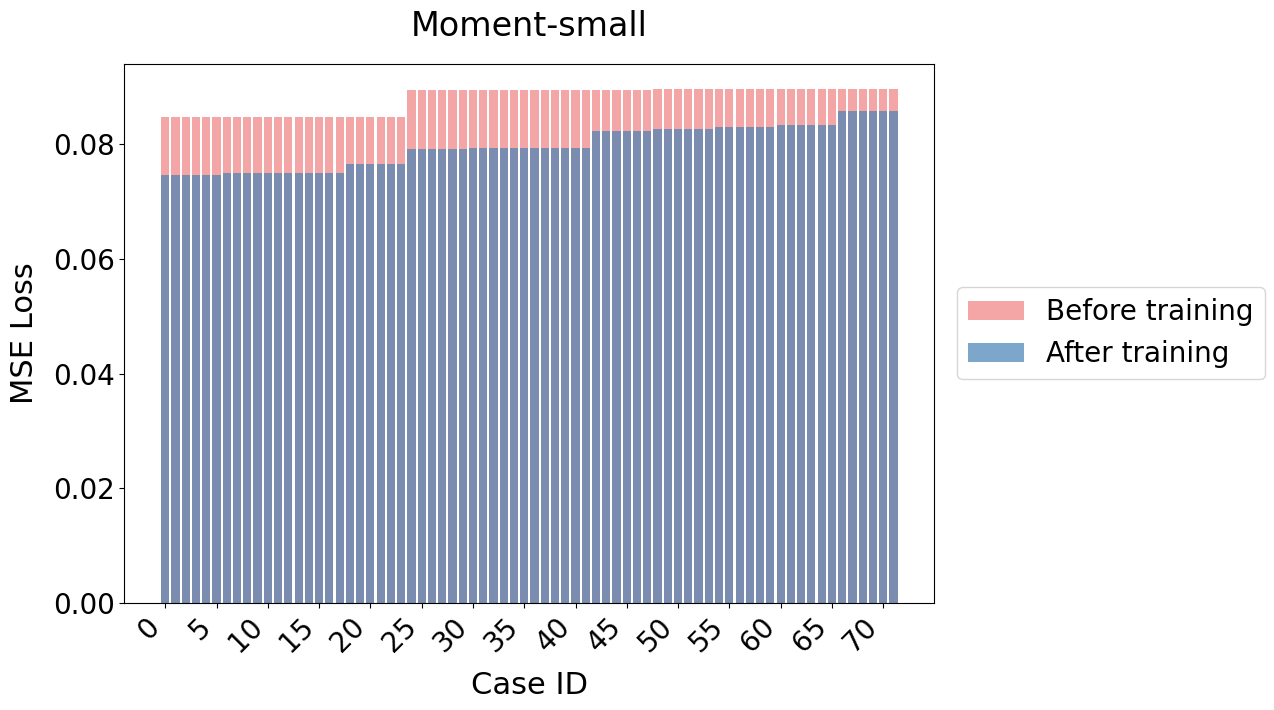

In [99]:
#plot_loss_comparison(df_small, mvp_loss, title="Moment-small Vs MVP", name = "small_vs_mvp", titlesize=24)
plot_loss_comparison(df_small, mvp_loss, title="Moment-small", name = "small_cases", titlesize=24, legend_position = "right")

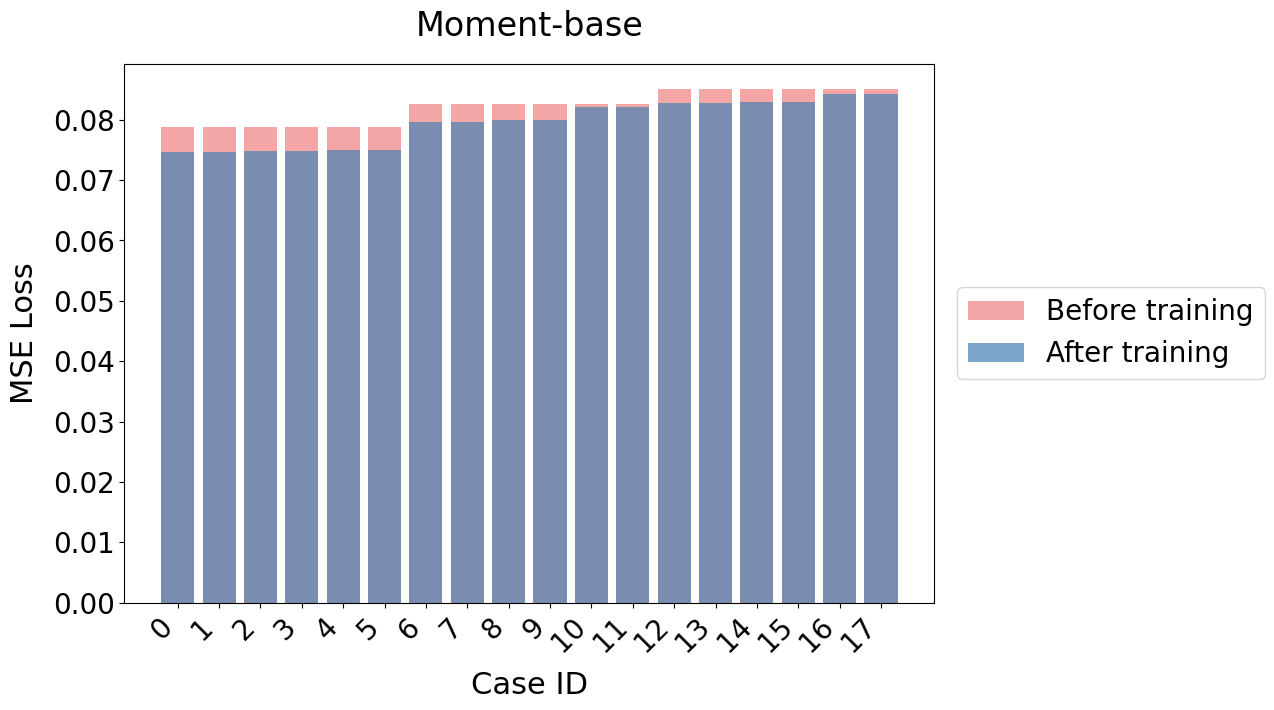

In [100]:
#plot_loss_comparison(df_base, mvp_loss, title="Moment-base Vs MVP", name = "base_vs_mvp", label_step = 1, titlesize=24)
plot_loss_comparison(df_base, mvp_loss, title="Moment-base", name = "base_cases", label_step = 1, titlesize=24, legend_position = "right")

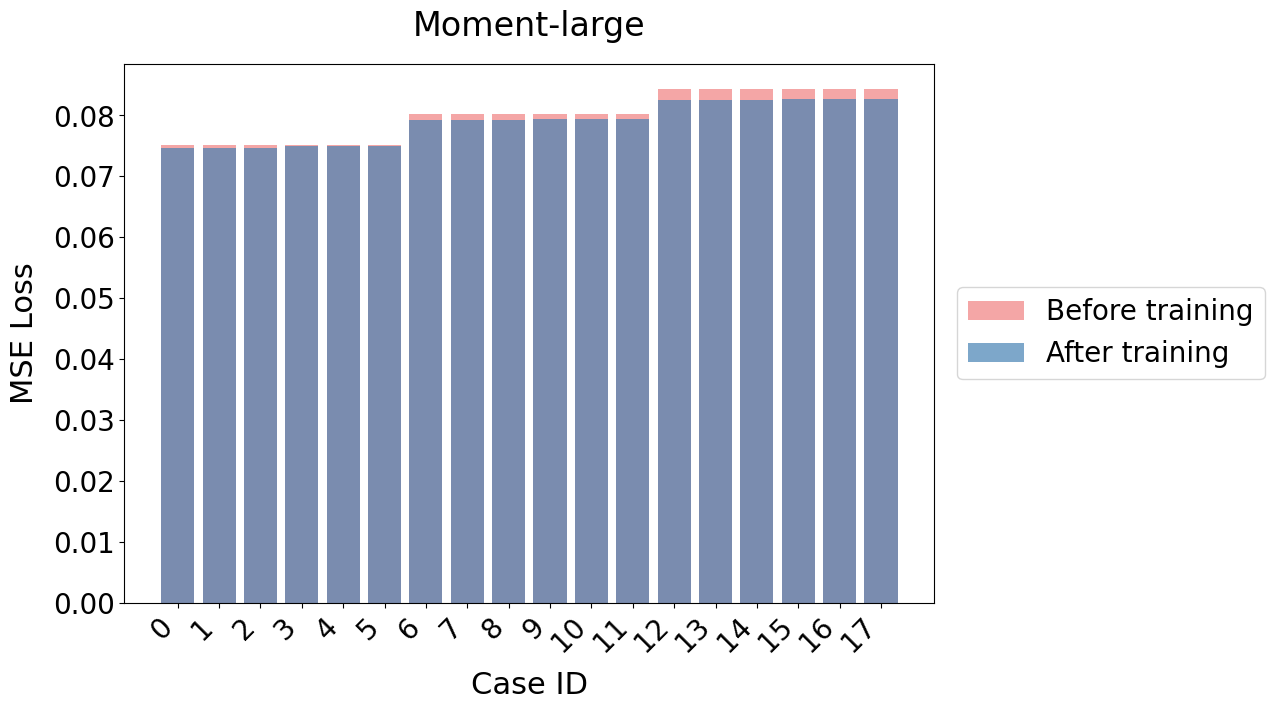

In [101]:
#plot_loss_comparison(df_large, mvp_loss, title="Moment-large Vs MVP", name="large_vs_mvp", label_step = 1, titlesize=24)
plot_loss_comparison(df_large, mvp_loss, title="Moment-large", name="large_cases", label_step = 1, titlesize=24, legend_position = "right")

In [102]:
df_small.columns

Index(['best_epoch', 'dataset_percent', 'masked_percent', 'n_windows',
       'first_mse', 'last_mse'],
      dtype='object')

In [103]:
def get_best_case(df, dataset_p, masked_p, n_epochs, n_windows):
    """Obtiene la mejor fila filtrando por dataset_percent, best_epoch, masked_percent y n_windows.
    Si no hay coincidencias, devuelve la fila con menor `last_mse`."""

    filtered = df[(df["dataset_percent"] == dataset_p) & 
                  (df["best_epoch"] == n_epochs) & 
                  (df["masked_percent"] == masked_p) &
                  (df["n_windows"] == n_windows)]
    
    if filtered.empty:
        print(f"⚠️ No se encontró coincidencia en el dataset. Seleccionando el de menor loss en {df.name}")
        return df.nsmallest(1, "last_mse").iloc[0]
    
    return filtered.iloc[0]

# Ejemplos de uso
print("--- SMALL ---")
print(get_best_case(df_small, 0.15, 0.25, 17, 1))
print("--- BASE ---")
print(get_best_case(df_base, 0.15, 0.25, 13, 5))
print("--- LARGE ---")
print(get_best_case(df_large, 0.2, 0.75, 17, 1))

--- SMALL ---
best_epoch         17.000000
dataset_percent     0.150000
masked_percent      0.250000
n_windows           1.000000
first_mse           0.084725
last_mse            0.074710
Name: 0, dtype: float64
--- BASE ---
best_epoch         13.000000
dataset_percent     0.150000
masked_percent      0.250000
n_windows           5.000000
first_mse           0.078768
last_mse            0.074833
Name: 1, dtype: float64
--- LARGE ---
best_epoch         17.000000
dataset_percent     0.200000
masked_percent      0.750000
n_windows           1.000000
first_mse           0.084293
last_mse            0.082591
Name: 15, dtype: float64


In [104]:
import matplotlib.pyplot as plt

def plot_best_case_comparison(df_small, df_base, df_large, mvp_loss, 
                              dataset_percent=(0.15, 0.25, 0.35), 
                              n_epochs=(20,20,20),
                              n_windows = (1,1,1),
                              masked_percent=(0.25, 0.25, 0.25), 
                              title="Best Model Comparison"):
    """
    Compara el mejor caso de cada dataset (`df_small`, `df_base`, `df_large`) con MVP,
    seleccionando la fila según los valores dados de `dataset_percent`, `n_epochs` y `masked_percent`.

    Parámetros:
    - df_small, df_base, df_large: DataFrames con los resultados de cada modelo.
    - mvp_loss: Valor de la pérdida de MVP.
    - dataset_percent: Tuple con los valores a seleccionar para cada dataset (small, base, large).
    - n_epochs: Número de épocas a seleccionar en cada dataset.
    - masked_percent: Tuple con los valores de `masked_percent` para cada dataset.
    - title: Título del gráfico.
    """

    # Agregar nombres a los DataFrames para depuración
    df_small.name, df_base.name, df_large.name = "df_small", "df_base", "df_large"

    # Seleccionar el mejor caso de cada dataset
    best_small = get_best_case(df_small, dataset_percent[0], masked_percent[0], n_epochs[0], n_windows[0])
    best_base = get_best_case(df_base, dataset_percent[1], masked_percent[1], n_epochs[1], n_windows[1])
    best_large = get_best_case(df_large, dataset_percent[2], masked_percent[2], n_epochs[2], n_windows[2])

    # Datos para el gráfico
    models = [
        f"Moment-Small",#\nepochs:{best_small['best_epoch']}\ntrain:{best_small['dataset_percent']}\nmask:{best_small['masked_percent']}",
        f"Moment-Base",#\nepochs:{best_base['best_epoch']}\ntrain:{best_base['dataset_percent']}\nmask:{best_base['masked_percent']}",
        f"Moment-Large",#\nepochs:{best_large['best_epoch']}\ntrain:{best_large['dataset_percent']}\nmask:{best_large['masked_percent']}",
        "MVP"
    ]

    losses = [best_small["last_mse"], best_base["last_mse"], best_large["last_mse"], mvp_loss]

    # Colores pastel suaves
    colors = ["#92C6FF", "#FFC49C", "#FFB6C1", "#A5DF82"]  # Azul pastel, verde pastel, naranja pastel, rosa pastel

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(models, losses, color=colors, alpha=0.8)

    # Añadir padding para evitar que la última barra se corte
    plt.ylim(0, max(losses) * 1.1)

    # Etiquetas y título
    plt.xlabel("Model")
    plt.ylabel("MSE Loss")
    plt.title(title)

    # Mostrar valores sobre las barras con padding adicional
    for i, v in enumerate(losses):
        plt.text(i, v + (max(losses) * 0.02), f"{v:.4f}", ha="center", fontsize=10)

    save2svg_pdf(name = "best_case_comparison")

    # Mostrar gráfico
    plt.show()


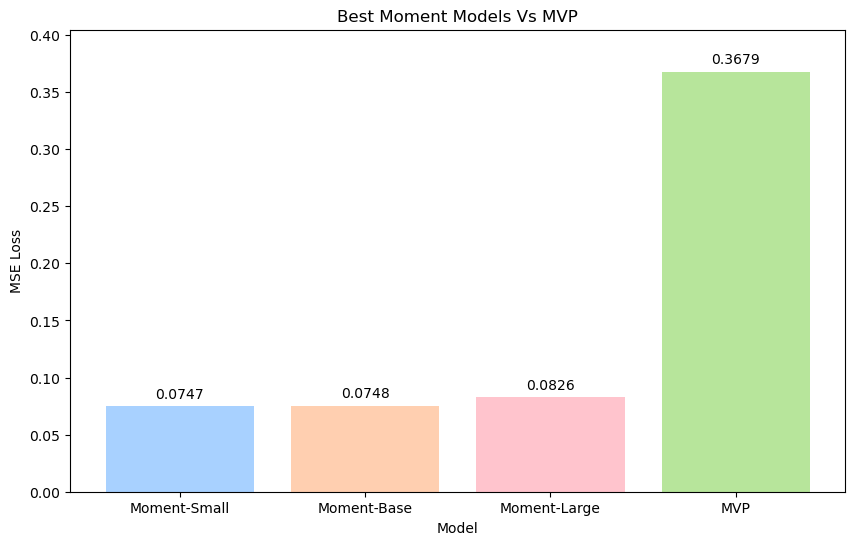

In [105]:
plot_best_case_comparison(
    df_small, df_base, df_large, mvp_loss, 
    dataset_percent=(0.15, 0.15, 0.2), 
    n_epochs=(17, 13, 17),
    n_windows = (1,5,1),
    masked_percent=(0.25, 0.25, 0.75),
    title="Best Moment Models Vs MVP"
)


In [106]:
import matplotlib.pyplot as plt

def plot_best_case_comparison(df_small, df_base, df_large, mvp_loss, 
                              dataset_percent=(0.15, 0.25, 0.35), 
                              n_epochs=(20,20,20),
                              n_windows=(1,1,1),
                              masked_percent=(0.25, 0.25, 0.25), 
                              title="Best Model Comparison"):
    """
    Compara el mejor caso de cada dataset (`df_small`, `df_base`, `df_large`) con MVP,
    seleccionando la fila según los valores dados de `dataset_percent`, `n_epochs`, `n_windows` y `masked_percent`.

    Parámetros:
    - df_small, df_base, df_large: DataFrames con los resultados de cada modelo.
    - mvp_loss: Valor de la pérdida de MVP.
    - dataset_percent: Tuple con los valores a seleccionar para cada dataset (small, base, large).
    - n_epochs: Número de épocas a seleccionar en cada dataset.
    - n_windows: Número de ventanas seleccionadas en cada dataset.
    - masked_percent: Tuple con los valores de `masked_percent` para cada dataset.
    - title: Título del gráfico.
    """

    # Agregar nombres a los DataFrames para depuración
    df_small.name, df_base.name, df_large.name = "df_small", "df_base", "df_large"

    # Seleccionar el mejor caso de cada dataset
    best_small = get_best_case(df_small, dataset_percent[0], masked_percent[0], n_epochs[0], n_windows[0])
    best_base = get_best_case(df_base, dataset_percent[1], masked_percent[1], n_epochs[1], n_windows[1])
    best_large = get_best_case(df_large, dataset_percent[2], masked_percent[2], n_epochs[2], n_windows[2])

    # Datos para el gráfico
    models = ["Moment-Small", "Moment-Base", "Moment-Large", "MVP"]
    losses = [best_small["last_mse"], best_base["last_mse"], best_large["last_mse"], mvp_loss]

    # Colores pastel suaves
    colors = ["#92C6FF", "#FFC49C", "#FFB6C1", "#A5DF82"]  # Azul, naranja, rosa, verde

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, losses, color=colors, edgecolor="black", linewidth=1, alpha=0.85)

    # Ajustar el tamaño de los ejes y espaciado
    plt.ylim(0, max(losses) * 1.15)  # Más espacio superior
    plt.xticks(fontsize=14)  # Tamaño de las etiquetas en el eje X
    plt.yticks(fontsize=14)  # Tamaño de las etiquetas en el eje Y
    plt.xlabel("Model", fontsize=16, labelpad=30)  # Más espacio con labelpad
    plt.ylabel("MSE Loss", fontsize=16, labelpad=30)

    # Mostrar valores sobre las barras con padding adicional
    for bar, loss in zip(bars, losses):
        plt.text(bar.get_x() + bar.get_width()/2, 
                 bar.get_height() + (max(losses) * 0.02), 
                 f"{loss:.4f}", 
                 ha="center", 
                 fontsize=12)#, 
                 #fontweight="bold")

    # Título del gráfico
    #plt.title(title, fontsize=16, fontweight="bold")
    plt.title(title, fontsize=18, pad=30)
    save2svg_pdf("moment_mvp_comparison")
    # Mostrar gráfico
    plt.show()


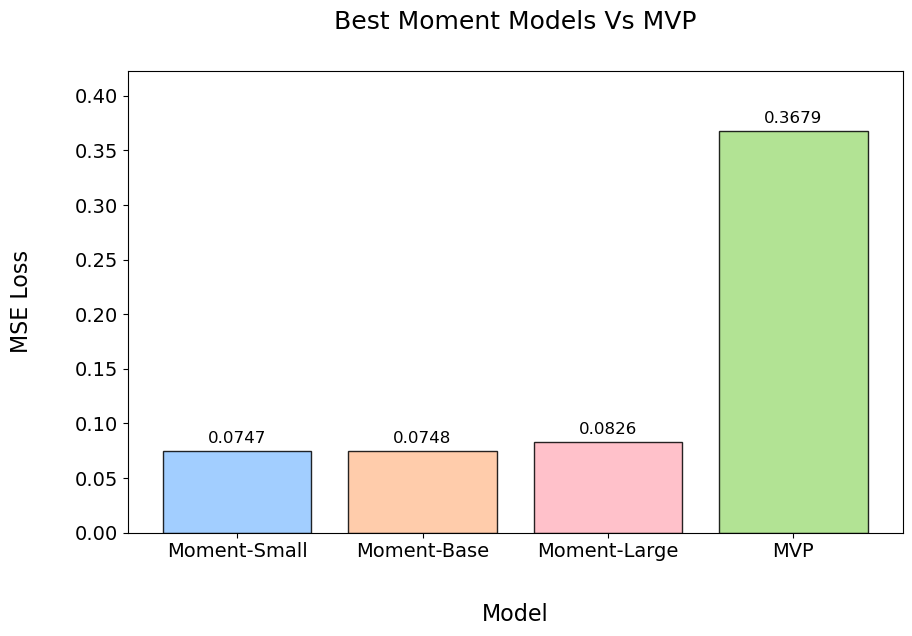

In [107]:
plot_best_case_comparison(
    df_small, df_base, df_large, mvp_loss, 
    dataset_percent=(0.15, 0.15, 0.2), 
    n_epochs=(17, 13, 17),
    n_windows = (1,5,1),
    masked_percent=(0.25, 0.25, 0.75),
    title="Best Moment Models Vs MVP"
)

## Trash but useful code

In [108]:
def check_layers(learn):
    # ANSI escape codes para color rojo y negrita en la consola
    RED = "\033[91m"
    BOLD = "\033[1m"
    RESET = "\033[0m"

    seen_layers = set()
    param_dict = {name: param.shape for name, param in learn.model.named_parameters()}

    def recurse_layers(module, prefix="", depth=0):
        """Recorre todas las capas del modelo y muestra solo sus parámetros directos."""
        for name, layer in module.named_children():  # Obtiene todos los submódulos
            full_name = f"{prefix}.{name}" if prefix else name

            # Aplicar negrita solo la primera vez que aparece un nombre de capa
            formatted_name = f"{BOLD}{name}{RESET}" if full_name not in seen_layers else name
            seen_layers.add(full_name)

            indentation = "\t" * depth  # Agregar tabulación según la profundidad
            
            # Filtrar solo los parámetros **directamente dentro** de esta capa
            param_info = [
                f"{n.split('.')[-1]}: {param_dict[n]}"
                for n in param_dict
                if n.startswith(full_name) and n.count('.') == full_name.count('.') + 1
            ]
            param_text = f" | Parámetros: {', '.join(param_info)}" if param_info else ""

            print(f"{indentation}[{depth}] Capa {formatted_name} {RED}[{type(layer).__name__}]{RESET}{param_text}")

            # Recursivamente mostrar las subcapas
            recurse_layers(layer, full_name, depth + 1)

    # Iniciar el recorrido desde el modelo completo
    recurse_layers(learn.model)

check_layers(enc_bkup_determinist)

[0] Capa backbone [Sequential]
	[1] Capa 0 [InceptionBlockPlus]
		[2] Capa inception [ModuleList]
			[3] Capa 0 [InceptionModulePlus]
				[4] Capa bottleneck [ConvBlock]
					[5] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 1, 1])
				[4] Capa convs [ModuleList]
					[5] Capa 0 [ConvBlock]
						[6] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 32, 39])
					[5] Capa 1 [ConvBlock]
						[6] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 32, 19])
					[5] Capa 2 [ConvBlock]
						[6] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 32, 9])
				[4] Capa mp_conv [Sequential]
					[5] Capa 0 [MaxPool1d]
					[5] Capa 1 [ConvBlock]
						[6] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 1, 1])
				[4] Capa concat [Concat]
				[4] Capa norm [BatchNorm1d] | Parámetros: weight: torch.Size([128]), bias: torch.Size([128])
				[4] Capa act [ReLU]
			[3] Capa 1 [InceptionModulePlus]
				[4] Capa bottleneck [ConvBlock]
					[5] Capa 0 [Conv1d] | Parámetros: weig

In [109]:
import random

# Tratando de evaluar MOMENT con el mismo conjunto de validación

In [110]:
dls.valid[0][0].shape

torch.Size([16, 1, 17])

In [111]:
config['r']

0.4

In [112]:
# Models
model_family = 'zeroshot-moment'
task = 'embedding'
enc_artifact_small_name = folder + model_family + '-small-' + task + ':v0'
enc_artifact_base_name  =  folder + model_family + '-base-' + task + ':v0'
enc_artifact_large_name = folder + model_family + '-large-' + task + ':v0'

## Evaluando moment-small

In [113]:
enc_artifact_small = wandb_api.artifact(enc_artifact_small_name, type='learner')
print(enc_artifact_small.name)
moment_small = enc_artifact_small.to_obj()

zeroshot-moment-small-embedding:v0


wandb: Downloading large artifact zeroshot-moment-small-embedding:v0, 144.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


In [114]:
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *

In [115]:
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

In [116]:
cfg_.show_attrdict(config)

alias: gtrends_kohls
analysis_mode: online
batch_size: 16
epochs: 200
mask_future: True
mask_stateful: False
mask_sync: False
mvp_ws: (12, 17)
norm_by_sample: False
norm_use_single_batch: False
r: 0.4
stride: 1
train_artifact: mi-santamaria/deepvats/gtrends_kohls:v2
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 17
wandb_group: None


In [117]:
from dvats.encoder import moment_set_masks, fine_tune_moment_eval_preprocess, Encoder

In [118]:
def eval_step(batch, metric, device, config, enc, cpu):
    """
    Performs a single evaluation step, computing MSE for a given batch.
    
    Args:
        batch (torch.Tensor): The batch of data.
        metric (EvalMSE): The evaluation metric.
        device (torch.device): The device to use (CPU/GPU).
        config (dict): The configuration dictionary.
        enc (Encoder): The encoder model.
    
    Returns:
        EvalMSE: Updated evaluation metric.
    """
    import torch

    window_size = batch.shape[2]

    # Ensure batch is on the correct device
    batch = batch.to(device)

    batch_masks = torch.ones((config['batch_size'], window_size), device=device).long()
    
    mask, bms = moment_set_masks(
        batch=batch,
        batch_masks=batch_masks,
        window_mask_percent=config['r'],
        mssg=enc.mssg,
        use_moment_masks=False,  # Ensures using MVP style mask
        mask_stateful=config['mask_stateful'],
        mask_future=config['mask_future'],
        mask_sync=config['mask_sync']
    )

    enc.model.eval()
    seed = 42
    enc._set_seed_(seed)
    np.random.seed(seed)
    random.seed(seed)
    old_value = None 
    if not cpu:
        torch.cuda.manual_seed_all(seed)
        torch.manual_seed(seed)
        # Ensure determinism in each function
        torch.backends.cudnn.deterministic  = True
        # Ensure the same function is allways used
        torch.backends.cudnn.benchmark      = False
        old_value = os.environ.get("CUBLAS_WORKSPACE_CONFIG")
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # Activar determinismo
        torch.cuda.synchronize()
    if cpu: 
        with torch.no_grad():
            enc.mssg.print(f"Executing in device {device}")

            # Execute forward pass
            output, success = enc.moment_safe_forward_pass(batch=batch, input_mask=bms, mask=mask)

            # If the forward pass was successful, compute evaluation metrics
            if output is not None and success:
                enc.mssg.print("Output is not None")
    
                # Get predictions and references (original data)
                predictions = output.reconstruction
                references = batch

                # Ensure valid shape and avoid NaN errors
                predictions, references = enc.fine_tune_moment_eval_preprocess(predictions, references)
    
                predictions = predictions.to(device)
                references = references.to(device)

                # Compute MSE
                metric.add_batch(predictions=predictions, references=references)
            if old_value is not None:
                os.environ["CUBLAS_WORKSPACE_CONFIG"] = old_value
            elif not cpu:
                del os.environ["CUBLAS_WORKSPACE_CONFIG"]
    if not cpu: 
        with torch.no_grad(), torch.cuda.device(device), torch.inference_mode():
            enc.mssg.print(f"Executing in device {device}")

            # Execute forward pass
            output, success = enc.moment_safe_forward_pass(batch=batch, input_mask=bms, mask=mask)

            # If the forward pass was successful, compute evaluation metrics
            if output is not None and success:
                enc.mssg.print("Output is not None")

                # Get predictions and references (original data)
                predictions = output.reconstruction
                references = batch

                # Ensure valid shape and avoid NaN errors
                predictions, references = enc.fine_tune_moment_eval_preprocess(predictions, references)

                predictions = predictions.to(device)
                references = references.to(device)
                # Compute MSE
                metric.add_batch(predictions=predictions, references=references)
    return metric

In [119]:
def eval_moment(enc, dl_eval, cpu):
    """
    Evaluates the encoder model on the given validation dataset.
    
    Args:
        enc (Encoder): The encoder model to evaluate.
        dl_eval (DataLoader or list): The validation dataset.
        cpu (bool): Whether to use CPU instead of GPU.
    
    Returns:
        None
    """

    # Ensure we are using the correct device
    print("-- Setup device, metrics & params --")
    device = "cpu" if cpu else torch.cuda.current_device()
    enc.cpu = cpu
    mse_metric = EvalMSE
    num_evaluation_steps = len(dl_eval)
    print("-- Move to device --", device)
    # Move model to correct device
    enc.model = enc.model.to(device)
    # 🔄 Asegurar que el `valid_dl` no tenga shuffle ni drop_last ---> Es una lista. No funciona aquí
    #dl_eval.shuffle_fn = lambda x: x  # Desactivar mezcla de datos
    #dl_eval.drop_last = False
    
    progress_bar = tqdm(range(num_evaluation_steps))
    print("-- Start batches --")
    for batch in dl_eval:
        # 🔹 Verificar si batch es una lista o tupla y extraer el primer tensor
        if isinstance(batch, (list, tuple)):
            batch = batch[0]  # Extraer el primer tensor
        elif isinstance(batch, dict): 
            batch = batch["input"]  # Ajusta según la clave del diccionario

        # 🔹 Asegurar que batch sea un tensor antes de moverlo a device
        if isinstance(batch, torch.Tensor):
            batch = batch.to(device)
        else:
            raise TypeError(f"Expected torch.Tensor but got {type(batch)}")
        mse_metric = eval_step(batch, mse_metric, device, config, enc, cpu)
        progress_bar.update(1)

    progress_bar.close()

    mse = mse_metric.compute(squared=False)
    enc.mssg.print_error(f"Eval results: {mse}.")
    return mse

### Without training

In [120]:
aux_enc = Encoder()
aux_enc.mssg.level = 1000

In [121]:
#| hide
dl_eval = deepcopy(dls.valid)
aux_enc.model = deepcopy(moment_small)
mse_small = eval_moment(aux_enc, dl_eval, False)

-- Setup device, metrics & params --
-- Move to device -- 0


  0% 0/8 [00:00<?, ?it/s]

-- Start batches --
[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic False
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 12% 1/8 [00:01<00:12,  1.75s/it]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 25% 2/8 [00:02<00:06,  1.08s/it]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 38% 3/8 [00:02<00:04,  1.14it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 50% 4/8 [00:03<00:03,  1.30it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 62% 5/8 [00:04<00:02,  1.39it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 75% 6/8 [00:04<00:01,  1.46it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 88% 7/8 [00:05<00:00,  1.52it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


100% 8/8 [00:06<00:00,  1.32it/s]

[0]  [ _check_value ] Eval results: {'mse': 0.10678985633945992}.


In [122]:
mse_small

{'mse': 0.10678985633945992}

## Evaluando moment-base

In [123]:
enc_artifact_base = wandb_api.artifact(enc_artifact_base_name, type='learner')
print(enc_artifact_base.name)
moment_base = enc_artifact_base.to_obj()

zeroshot-moment-base-embedding:v0


wandb: Downloading large artifact zeroshot-moment-base-embedding:v0, 432.97MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.1


In [124]:
aux_enc = Encoder()
aux_enc.mssg.level = 1000
dl_eval = deepcopy(dls.valid)
aux_enc.model = deepcopy(moment_base)
mse_base = eval_moment(aux_enc, dl_eval, True)

-- Setup device, metrics & params --
-- Move to device -- cpu


  0% 0/8 [00:00<?, ?it/s]

-- Start batches --
[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 12% 1/8 [00:00<00:05,  1.33it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 25% 2/8 [00:01<00:04,  1.43it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 38% 3/8 [00:02<00:03,  1.48it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 50% 4/8 [00:02<00:02,  1.50it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 62% 5/8 [00:03<00:02,  1.50it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 75% 6/8 [00:04<00:01,  1.50it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 88% 7/8 [00:04<00:00,  1.50it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


100% 8/8 [00:05<00:00,  1.50it/s]

[0]  [ _check_value ] Eval results: {'mse': 0.10111009357041022}.


## Evaluando moment-large

In [125]:
enc_artifact_large = wandb_api.artifact(enc_artifact_large_name, type='learner')
print(enc_artifact_large.name)
moment_large = enc_artifact_large.to_obj()

zeroshot-moment-large-embedding:v0


wandb: Downloading large artifact zeroshot-moment-large-embedding:v0, 1321.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:9.4


In [126]:
aux_enc = Encoder()
aux_enc.mssg.level = 1000
dl_eval = deepcopy(dls.valid)
aux_enc.model = deepcopy(moment_large)
mse_large = eval_moment(aux_enc, dl_eval, True)

-- Setup device, metrics & params --
-- Move to device -- cpu


  0% 0/8 [00:00<?, ?it/s]

-- Start batches --
[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 12% 1/8 [00:01<00:11,  1.58s/it]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 25% 2/8 [00:03<00:09,  1.51s/it]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 38% 3/8 [00:03<00:06,  1.21s/it]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 50% 4/8 [00:04<00:04,  1.07s/it]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 62% 5/8 [00:05<00:02,  1.02it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 75% 6/8 [00:06<00:01,  1.00it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 88% 7/8 [00:07<00:00,  1.01it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


100% 8/8 [00:08<00:00,  1.06s/it]

[0]  [ _check_value ] Eval results: {'mse': 0.09932331356765771}.


### Best cases

In [127]:
common_args = {
    "X": df,
    "stride": 1,
    "batch_size": config['batch_size'],
    "cpu": False,
    "to_numpy": False,
    "time_flag": True,
    "n_windows": None,
    "n_windows_percent": None,
    "shot": True,
    "eval_pre": True,
    "eval_post": True,
    "lr": config['r'], #use enc_run lr,
    "lr_scheduler_flag": True, # False
    "lr_scheduler_name": "cosine_with_restarts",
    "lr_scheduler_num_warmup_steps": 100, # None
    "window_sizes": [17],
    "full_dataset": True,
    "window_sizes_offset": 0.05,
    "windows_min_distance": 0, #int(np.ceil(1.5*enc_input.shape[0]/100)),
    "print_to_path": True,
    "print_both": False,
    "print_path": "./logs.txt",
    "print_mode": "a",
    "use_moment_masks": True,
    "mask_stateful": config['mask_stateful'],
    "mask_future": config['mask_future'],
    "mask_sync": config['mask_sync'],
    "analysis_mode": config['analysis_mode'],
    "use_wandb": config['use_wandb'],
    "norm_by_sample": config['norm_by_sample'],
    "norm_use_single_batch": config['norm_use_single_batch'],
    "show_plot": True,
    "metrics": [EvalMSE],
    "metrics_args": [{'squared': False}, {'squared': True}, {}, {}],
    "metrics_names":["mse"],
    "metrics_dict": None,
    "criterion": torch.nn.MSELoss(),
    # Segmentation
    #"criterion": SoftDTWLossPyTorch(gamma=5.0, normalize = True, dist_func = None),
    "mix_windows": True
}

In [128]:
def fine_tune_model(model_case, masked_percent, dataset_percent, n_epochs, sizes = 0):
    result = fine_tune(
        enc_learn           = model_case,
        window_mask_percent = masked_percent,
        training_percent    = dataset_percent,
        validation_percent  = 0.3,
        num_epochs          = n_epochs,
        n_window_sizes      = sizes,
        verbose             = verbose,
        register_errors     = True,
        save_best_or_last   = True, # only available for moment,
        #force_best_lr       = True,
        **common_args    
    )
    return result[7]

In [129]:
aux_enc = Encoder()
aux_enc.mssg.level = 1000
dl_eval = deepcopy(dls.valid)
model_case = deepcopy(moment_small)
aux_enc.model = model_case
mse_small_pre = eval_moment(aux_enc, dl_eval, False)
aux_enc.model = fine_tune_model(model_case, 0.25, 0.15, 17, sizes = 1)

-- Setup device, metrics & params --
-- Move to device -- 0


  0% 0/8 [00:00<?, ?it/s]

-- Start batches --
[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 12% 1/8 [00:00<00:04,  1.61it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 25% 2/8 [00:01<00:03,  1.62it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 38% 3/8 [00:01<00:03,  1.60it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 50% 4/8 [00:02<00:02,  1.63it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 62% 5/8 [00:03<00:01,  1.63it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 75% 6/8 [00:03<00:01,  1.63it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 88% 7/8 [00:04<00:00,  1.62it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


100% 8/8 [00:04<00:00,  1.63it/s]

[0]  [ _check_value ] Eval results: {'mse': 0.10678985633945992}.


Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 68/68 [00:36<00:00,  1.88it/s]
100% 8/8 [00:05<00:00,  1.38it/s]


In [130]:
mse_small_post = eval_moment(aux_enc, dl_eval, False)

-- Setup device, metrics & params --
-- Move to device -- 0


  0% 0/8 [00:00<?, ?it/s]

-- Start batches --
[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 12% 1/8 [00:00<00:04,  1.59it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 25% 2/8 [00:01<00:03,  1.62it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 38% 3/8 [00:01<00:03,  1.62it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 50% 4/8 [00:02<00:02,  1.63it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 62% 5/8 [00:03<00:01,  1.63it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 75% 6/8 [00:03<00:01,  1.63it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 88% 7/8 [00:04<00:00,  1.63it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


100% 8/8 [00:04<00:00,  1.63it/s]

[0]  [ _check_value ] Eval results: {'mse': 0.10255817015315233}.


In [131]:
print("pre:", mse_small_pre)
print("post:", mse_small_post)
print("pre-post:", mse_small_pre['mse']-mse_small_post['mse'])
print("pre > post?", mse_small_pre['mse'] > mse_small_post['mse'])

pre: {'mse': 0.10678985633945992}
post: {'mse': 0.10255817015315233}
pre-post: 0.004231686186307593
pre > post? True


In [132]:
aux_enc = Encoder()
aux_enc.mssg.level = 1000
dl_eval = deepcopy(dls.valid)
model_case = deepcopy(moment_base)
aux_enc.model = model_case
mse_base_pre = eval_moment(aux_enc, dl_eval, False)
aux_enc.model = fine_tune_model(model_case, 0.25, 0.15, 13, sizes = 5)

-- Setup device, metrics & params --
-- Move to device -- 0


  0% 0/8 [00:00<?, ?it/s]

-- Start batches --
[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 12% 1/8 [00:00<00:04,  1.56it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 25% 2/8 [00:01<00:03,  1.60it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 38% 3/8 [00:01<00:03,  1.60it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 50% 4/8 [00:02<00:02,  1.61it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 62% 5/8 [00:03<00:01,  1.62it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 75% 6/8 [00:03<00:01,  1.61it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 88% 7/8 [00:04<00:00,  1.62it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


100% 8/8 [00:04<00:00,  1.61it/s]

[0]  [ _check_value ] Eval results: {'mse': 0.1011100936386437}.


Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.36it/s]
100% 52/52 [00:28<00:00,  1.80it/s]
100% 8/8 [00:05<00:00,  1.35it/s]


In [133]:
mse_base_post = eval_moment(aux_enc, dl_eval, False)

-- Setup device, metrics & params --
-- Move to device -- 0


  0% 0/8 [00:00<?, ?it/s]

-- Start batches --
[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 12% 1/8 [00:00<00:04,  1.52it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 25% 2/8 [00:01<00:03,  1.56it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 38% 3/8 [00:01<00:03,  1.56it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 50% 4/8 [00:02<00:02,  1.58it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 62% 5/8 [00:03<00:01,  1.59it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 75% 6/8 [00:03<00:01,  1.60it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 88% 7/8 [00:04<00:00,  1.59it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


100% 8/8 [00:05<00:00,  1.59it/s]

[0]  [ _check_value ] Eval results: {'mse': 0.10292088469545815}.


In [134]:
print("pre:", mse_base_pre)
print("post:", mse_base_post)
print("pre-post:", mse_base_pre['mse']-mse_base_post['mse'])
print("pre > post?", mse_base_pre['mse'] > mse_base_post['mse'])

pre: {'mse': 0.1011100936386437}
post: {'mse': 0.10292088469545815}
pre-post: -0.001810791056814448
pre > post? False


In [135]:
aux_enc = Encoder()
aux_enc.mssg.level = 1000
dl_eval = deepcopy(dls.valid)
model_case = deepcopy(moment_large)
aux_enc.model = model_case
mse_large_pre = eval_moment(aux_enc, dl_eval, False)
aux_enc.model = fine_tune_model(model_case, 0.75,0.2, 17, sizes = 1)

-- Setup device, metrics & params --
-- Move to device -- 0


  0% 0/8 [00:00<?, ?it/s]

-- Start batches --
[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 12% 1/8 [00:00<00:04,  1.46it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 25% 2/8 [00:01<00:04,  1.50it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 38% 3/8 [00:01<00:03,  1.51it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 50% 4/8 [00:02<00:02,  1.52it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 62% 5/8 [00:03<00:01,  1.52it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 75% 6/8 [00:03<00:01,  1.53it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 88% 7/8 [00:04<00:00,  1.52it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


100% 8/8 [00:05<00:00,  1.51it/s]

[0]  [ _check_value ] Eval results: {'mse': 0.0993233122782215}.


Initialize Windowed Dataset


100% 8/8 [00:06<00:00,  1.26it/s]
100% 85/85 [00:53<00:00,  1.60it/s]
100% 8/8 [00:06<00:00,  1.26it/s]


In [136]:
mse_large_post = eval_moment(aux_enc, dl_eval, False)

-- Setup device, metrics & params --
-- Move to device -- 0


  0% 0/8 [00:00<?, ?it/s]

-- Start batches --
[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 12% 1/8 [00:00<00:04,  1.48it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 25% 2/8 [00:01<00:04,  1.49it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 38% 3/8 [00:02<00:03,  1.49it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 50% 4/8 [00:02<00:02,  1.50it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 62% 5/8 [00:03<00:02,  1.50it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 75% 6/8 [00:04<00:01,  1.50it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


 88% 7/8 [00:04<00:00,  1.50it/s]

[0]  [ _check_value ] Saving benchmark False
[0]  [ _check_value ] Saving deterministic True
[0]  [ _check_value ] Changing benchmark to False
[0]  [ _check_value ] Changing deterministic to True


100% 8/8 [00:05<00:00,  1.50it/s]

[0]  [ _check_value ] Eval results: {'mse': 0.09594449391176499}.


In [137]:
print("pre:", mse_large_pre)
print("post:", mse_large_post)
print("pre-post:", mse_large_pre['mse']-mse_large_post['mse'])
print("pre > post?", mse_large_pre['mse'] > mse_large_post['mse'])

pre: {'mse': 0.0993233122782215}
post: {'mse': 0.09594449391176499}
pre-post: 0.0033788183664565097
pre > post? True


# La comparación correcta

In [138]:
import matplotlib.pyplot as plt

def plot_best_case_comparison(small_loss, base_loss, large_loss, mvp_loss, title="Best Model Comparison", best=False):
    """
    Generates a bar plot comparing the best models based on their MSE loss.
    
    Args:
        small_loss (float): MSE loss for the Moment-Small model.
        base_loss (float): MSE loss for the Moment-Base model.
        large_loss (float): MSE loss for the Moment-Large model.
        mvp_loss (float): MSE loss for the MVP model.
        title (str): The title of the plot. Default is "Best Model Comparison".
    
    Returns:
        None. Displays and saves the plot.
    """
    
    # Model names and corresponding losses
    models = ["Moment-Small", "Moment-Base", "Moment-Large", "MVP"]
    losses = [small_loss, base_loss, large_loss, mvp_loss]
    
    # Soft pastel colors for visualization
    colors = ["#92C6FF", "#FFC49C", "#FFB6C1", "#A5DF82"]  # Blue, Orange, Pink, Green
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, losses, color=colors, edgecolor="black", linewidth=1, alpha=0.85)

    # Adjust y-axis limits to provide more space for labels
    y_max = max(losses) * 1.15  # Add 15% extra space above the highest bar
    plt.ylim(0, y_max)
    
    # Set axis labels with appropriate spacing
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Model", fontsize=16, labelpad=10)
    plt.ylabel("MSE Loss", fontsize=16, labelpad=10)

    # Display values above bars with dynamic padding
    for bar, loss in zip(bars, losses):
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + (y_max * 0.02),  # Dynamically adjust position
            f"{loss:.4f}", 
            ha="center", 
            fontsize=12
        )

    # Set title with additional padding
    plt.title(title, fontsize=18, pad=20)

    # Save the plot in both SVG and PDF formats
    if best:
        save2svg_pdf("moment_mvp_comparison_best")
    else:
        save2svg_pdf("moment_mvp_comparison")

    # Show the plot
    plt.show()

In [139]:
import matplotlib.pyplot as plt

def plot_best_case_comparison(small_loss, base_loss, large_loss, mvp_loss, title="Best Model Comparison", best=False, titlesize=20):
    """
    Generates a bar plot comparing the best models based on their MSE loss.
    
    Args:
        small_loss (float): MSE loss for the Moment-Small model.
        base_loss (float): MSE loss for the Moment-Base model.
        large_loss (float): MSE loss for the Moment-Large model.
        mvp_loss (float): MSE loss for the MVP model.
        title (str): The title of the plot. Default is "Best Model Comparison".
        best (bool): Whether to save the plot with a special filename.
        titlesize (int): Size of the title text.
    
    Returns:
        None. Displays and saves the plot.
    """
    
    # Model names and corresponding losses
    models = ["Small", "Base", "Large", "MVP"]
    losses = [small_loss, base_loss, large_loss, mvp_loss]
    
    # Soft pastel colors for visualization
    colors = ["#92C6FF", "#FFC49C", "#FFB6C1", "#A5DF82"]  # Blue, Orange, Pink, Green
    
    # Define proportional font sizes
    labelsize = titlesize * 0.8   # 80% of title size
    ticksize = titlesize * 0.7    # 70% of title size
    textsize = titlesize * 0.6    # 60% of title size
    pad_title = titlesize         # Same as title size
    pad_labels = titlesize * 0.5  # 50% of title size

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, losses, color=colors, edgecolor="black", linewidth=1, alpha=0.85)

    # Adjust y-axis limits to provide more space for labels
    y_max = max(losses) * 1.15  # Add 15% extra space above the highest bar
    plt.ylim(0, y_max)
    
    # Set axis labels with appropriate spacing
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.xlabel("Model", fontsize=labelsize, labelpad=pad_labels)
    plt.ylabel("MSE Loss", fontsize=labelsize, labelpad=pad_labels)

    # Display values above bars with dynamic padding
    for bar, loss in zip(bars, losses):
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + (y_max * 0.02),  # Dynamically adjust position
            f"{loss:.4f}", 
            ha="center", 
            fontsize=textsize
        )

    # Set title with additional padding
    plt.title(title, fontsize=titlesize, pad=pad_title)

    # Save the plot in both SVG and PDF formats
    filename = "moment_mvp_comparison_best" if best else "moment_mvp_comparison"
    save2svg_pdf(filename)

    # Show the plot
    plt.show()


In [140]:
mvp_loss

0.3678569134925302

In [141]:
mse_small

{'mse': 0.10678985633945992}

In [142]:
print("Hola")

Hola


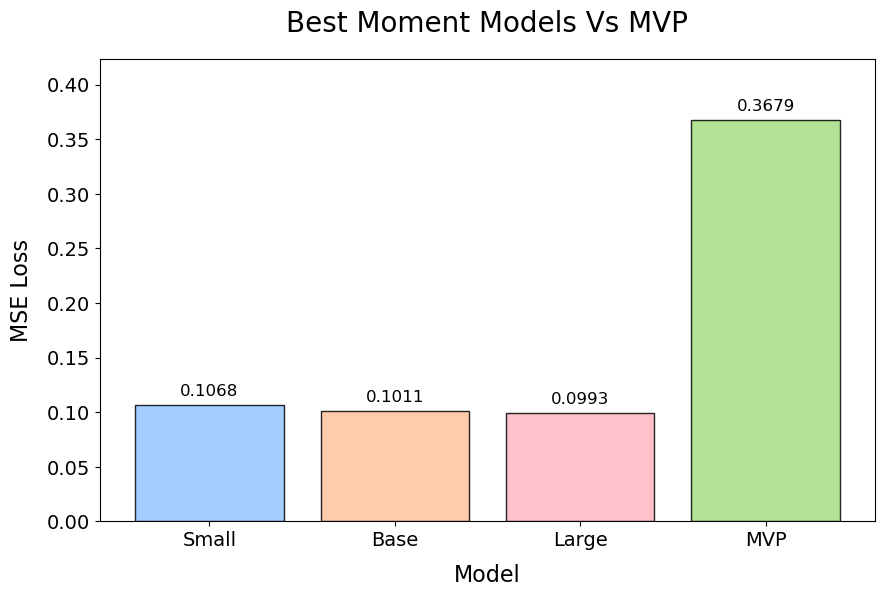

In [143]:
plot_best_case_comparison(
    mse_small['mse'], 
    mse_base['mse'],
    mse_large['mse'],
    mvp_loss,
    title="Best Moment Models Vs MVP"
)

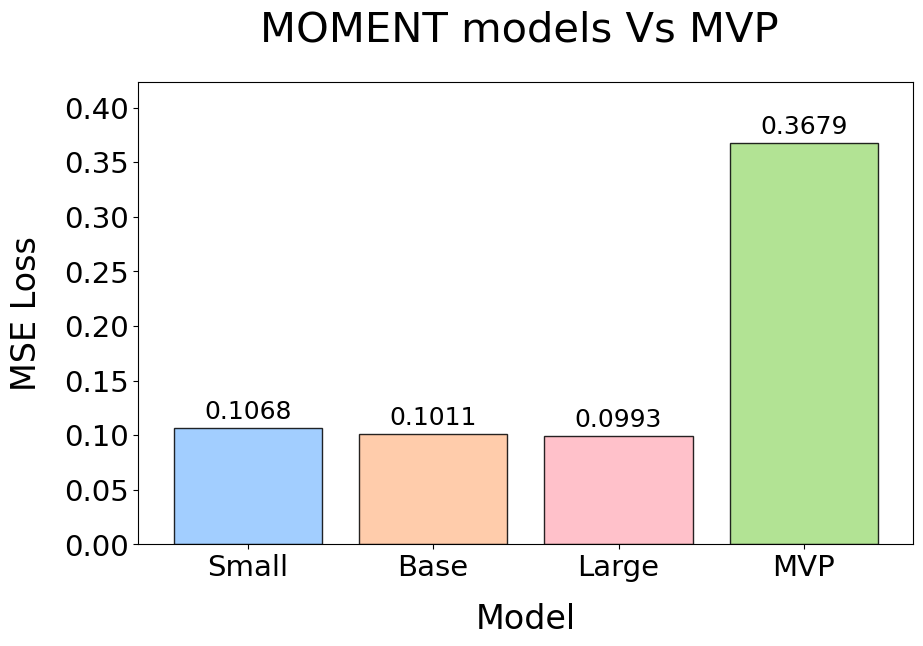

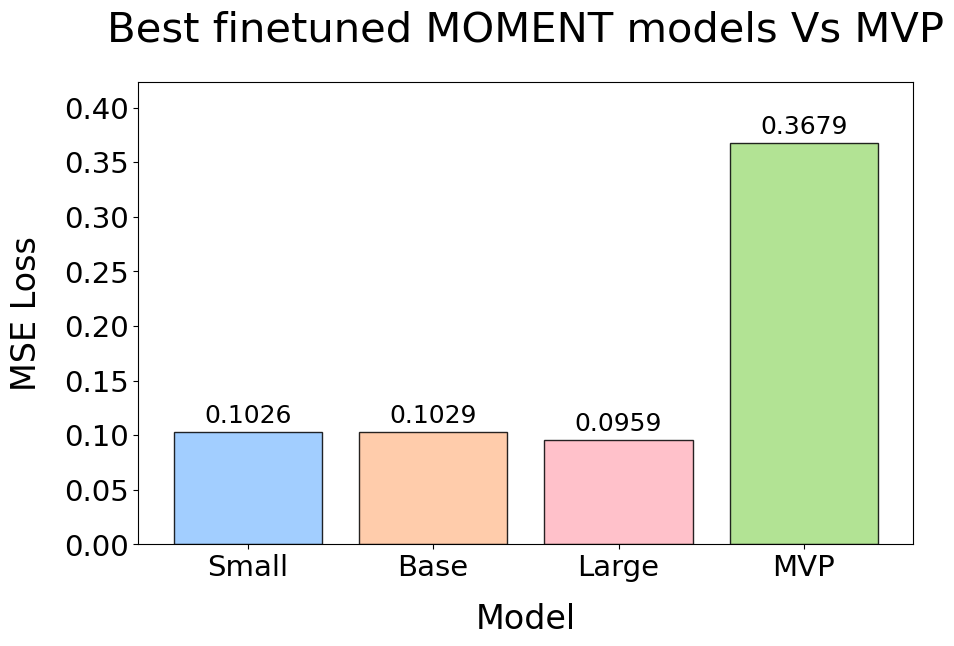

In [144]:
plot_best_case_comparison(
    mse_small_pre['mse'], 
    mse_base_pre['mse'],
    mse_large_pre['mse'],
    mvp_loss,
    title="MOMENT models Vs MVP ",
    titlesize=30
)
plot_best_case_comparison(
    mse_small_post['mse'], 
    mse_base_post['mse'],
    mse_large_post['mse'],
    mvp_loss,
    title="Best finetuned MOMENT models Vs MVP",
    best = True,
    titlesize=30
)

## Trying to make the analysis with all the distances

In [145]:
moment_small

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=512, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (

In [146]:
def eval_case(model, a,b,c, mssg, dls, cpu = False):
    aux_enc = Encoder()
    aux_enc.mssg = mssg
    dl_eval = deepcopy(dls.valid)
    model_case = deepcopy(model)
    aux_enc.model = model_case
    #mse_small_pre = eval_moment(aux_enc, dl_eval, False)
    aux_enc.model = fine_tune_model(model_case, a, b, c, sizes = 1)
    mse_small_post = eval_moment(aux_enc, dl_eval, cpu)
    return mse_small_post

In [147]:
enc_artifact_small = wandb_api.artifact(enc_artifact_small_name, type='learner')
print(enc_artifact_small.name)
moment_small = enc_artifact_small.to_obj()
enc_artifact_base = wandb_api.artifact(enc_artifact_base_name, type='learner')
print(enc_artifact_base.name)
moment_small = enc_artifact_base.to_obj()
enc_artifact_large = wandb_api.artifact(enc_artifact_large_name, type='learner')
print(enc_artifact_large.name)
moment_small = enc_artifact_large.to_obj()

zeroshot-moment-small-embedding:v0


wandb: Downloading large artifact zeroshot-moment-small-embedding:v0, 144.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


zeroshot-moment-base-embedding:v0


wandb: Downloading large artifact zeroshot-moment-base-embedding:v0, 432.97MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3


zeroshot-moment-large-embedding:v0


wandb: Downloading large artifact zeroshot-moment-large-embedding:v0, 1321.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:4.0


In [148]:
def build_dls(df, dataset_percent, size, mssg):
    enc_input, window_sizes = _set_enc_input(
        mssg  = mssg, 
        X      = df, 
        stride = 1,
        batch_size = 16,
        validation_percent = 0.3,
        training_percent = dataset_percent,
        window_mask_percent = 0.75,
        window_sizes = [size],
        n_window_sizes = 1,
        full_dataset = True,
        mix_windows = True,
        cpu = False
    )
    # 🔹 Convertir el generador en una lista de tensores y asegurarse de que están en `cuda:0`
    train_batches = [batch.to(device, dtype=torch.float32) for batch in enc_input.data.train_batches()]
    valid_batches = [batch.to(device, dtype=torch.float32) for batch in enc_input.data.valid_batches()]
    train_dataset = FlattenedDataset(train_batches)
    valid_dataset = FlattenedDataset(valid_batches)
    train_loader = FastaiDataLoader(
        train_dataset, 
        bs=16,  
        shuffle=True#, 
        #collate_fn=lambda x: tuple(zip(*x))  # 🔹 Esto mantiene la estructura de tupla
    )

    valid_loader = FastaiDataLoader(
        valid_dataset, 
        bs=16,  
        shuffle=False#, 
        #collate_fn=lambda x: tuple(zip(*x))  # 🔹 Igual para validación
    )
    dls = DataLoaders(to_device(train_loader, device), to_device(valid_loader, device))
    return dls

import torch
import gc

def clean_cuda():
    """
    Cleans CUDA memory by deleting variables, emptying the cache, and forcing garbage collection.

    Returns:
        None.
    """
    # Delete all tensors in CUDA to free memory
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    
    # Run garbage collection
    gc.collect()

    # Check available memory
    print("CUDA memory cleaned. Current allocated:", torch.cuda.memory_allocated() / 1e6, "MB")
    print("CUDA cached memory:", torch.cuda.memory_reserved() / 1e6, "MB")


    
def different_sizes_analysis(mvp, min_size, max_size, steps = 1, dataset_percents = [0.25, 0.5, 0.75, 1], cpu = False):
    model = deepcopy(mvp)
    results = []
    model = deepcopy(enc_bkup_determinist)
    mssg = ut.Mssg(verbose=1)    
    num_evaluation_steps = len(dataset_percents)*(max_size-min_size+1)
    progress_bar = tqdm(range(num_evaluation_steps))
    for dataset_percent in dataset_percents:
        for size in range(min_size,max_size+1, steps):
            result = {
               "dataset_percent": dataset_percent,
                "size": size,
                "mvp": np.nan,
                "small": np.nan,
                "base": np.nan, 
                "large": np.nan
            }
            mssg.print_error("Get DataLoaders")
            # Construir los DataLoaders
            dls = build_dls(df, dataset_percent, size, mssg)
            move_to_cpu(model, dls)
            # Ejecutar la validación con EvalMSE
            dl_eval = deepcopy(dls.valid)
            try: 
                _, result['mvp'] = mvp_validate_with_evalmse(encoder=model, dl=dl_eval, iterations=1)
            except:
                print("Failed")
            try: 
                result['small'] = eval_case(moment_small, 0.25, 0.15, 17, mssg, dls, cpu)
            except:
                print("Failed")
            try: 
                result['base'] = eval_case(moment_base, 0.25, 0.15, 13, mssg, dls, cpu)
            except:
                print("Failed")
            try: 
                result['large'] = eval_case(moment_large, 0.75, 0.2, 17, mssg, dls, cpu)
            except: 
                print("Failed")
            # Almacenar los resultados en la lista
            results.append(result)
            progress_bar.update(1)
            clean_cuda()
    return results

In [ ]:
results = different_sizes_analysis(enc_bkup_determinist, 14, 18)
# Convertir resultados en DataFrame
results_df = pd.DataFrame(results)

  0% 0/20 [00:00<?, ?it/s]

[1]  [ different_sizes_analysis ] Get DataLoaders
[1]  [ _set_enc_input ] is none enc_input? True
[1]  [ _set_enc_input ] About to get the windows
Initialize Windowed Dataset
[1]  [ _set_enc_input ] About to get the encoder input
✅ Los tensores están correctamente en CUDA.

📌 FlattenedDataset creado con 97 muestras
📌 Shape de una muestra: torch.Size([1, 14])
✅ Los tensores están correctamente en CUDA.

📌 FlattenedDataset creado con 119 muestras
📌 Shape de una muestra: torch.Size([1, 14])
✅ Todo ha sido movido a CPU correctamente.

🔍 Iniciando validación con EvalMSE en múltiples iteraciones...
✅ Modelo en modo evaluación.
✅ DataLoader tiene 8 batches disponibles.



Validating:   0% 0/8 [00:00<?, ?batch/s]
Validating:  38% 3/8 [00:00<00:00, 22.12batch/s]
Validating:  75% 6/8 [00:00<00:00, 18.34batch/s]
Validating: 100% 8/8 [00:00<00:00, 17.54batch/s]



✅ Validación completada con éxito.
Initialize Windowed Dataset



  0% 0/8 [00:00<?, ?it/s]
 12% 1/8 [00:02<00:14,  2.10s/it]
 25% 2/8 [00:03<00:09,  1.51s/it]
 38% 3/8 [00:04<00:06,  1.32s/it]
 50% 4/8 [00:05<00:04,  1.24s/it]
 62% 5/8 [00:06<00:03,  1.19s/it]
 75% 6/8 [00:07<00:02,  1.17s/it]
 88% 7/8 [00:08<00:01,  1.15s/it]
100% 8/8 [00:09<00:00,  1.23s/it]

  0% 0/68 [00:00<?, ?it/s]
  1% 1/68 [00:02<02:20,  2.10s/it]
  3% 2/68 [00:03<01:34,  1.43s/it]
  4% 3/68 [00:04<01:19,  1.22s/it]
  6% 4/68 [00:05<01:12,  1.13s/it]
  7% 5/68 [00:07<01:36,  1.54s/it]
  9% 6/68 [00:08<01:23,  1.34s/it]
 10% 7/68 [00:09<01:14,  1.22s/it]

In [ ]:
print("Ended")

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df.head()

In [ ]:
# Verificar si hay al menos un valor no NaN en las columnas de la derecha
cols_to_check = ["small", "base", "large"]  # Ajusta según los nombres de tus columnas
has_non_nan = results_df[cols_to_check].notna().any().any()
print(has_non_nan)

In [ ]:
def format_results(df, cols_to_clean):
    """
    Extracts only the float values from dictionary-like columns.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the results.
        cols_to_clean (list): List of columns that may contain dictionaries.

    Returns:
        pd.DataFrame: A formatted DataFrame with extracted float values.
    """
    df_cleaned = df.copy()
    
    for col in cols_to_clean:
        df_cleaned[col] = df_cleaned[col].apply(lambda x: x['mse'])
    
    return df_cleaned


In [ ]:

# Columnas que contienen diccionarios
cols_to_clean = ["small", "base", "large"]

# Aplicar la función al DataFrame
formatted_df = format_results(results_df, cols_to_clean)
formatted_df['mvp'] = formatted_df['mvp'].apply(lambda x: x.item())

In [ ]:
formatted_df

In [ ]:
formatted_df.plot()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

def plot_mean_loss_by_size(df, title="Mean Loss by Window Size"):
    """
    Plots the mean loss for each model (MVP, Small, Base, Large) grouped by window size
    and provides download links for PDF and SVG.

    Args:
        df (pd.DataFrame): DataFrame containing the results.
        title (str): Title of the plot.

    Returns:
        None. Displays the plot and download links.
    """
    # Compute mean losses grouped by size
    mean_losses = df.groupby("size")[["mvp", "small", "base", "large"]].mean()

    # Create the figure
    plt.figure(figsize=(10, 6))
    colors = ["#A5DF82", "#92C6FF", "#FFC49C", "#FFB6C1"]
    colors = ["#{:02x}{:02x}{:02x}".format(
        *[max(0, min(int(color[i:i+2], 16) * (1 - x), 255)) 
          for i in (1, 3, 5)]
    ) for color in colors
    # Plot each model's mean loss across sizes
    for column, color, label in zip(mean_losses.columns, colors,
                                    ["MVP", "Moment-Small", "Moment-Base", "Moment-Large"]):
        plt.plot(mean_losses.index, mean_losses[column], marker='o', linestyle='-', label=label, color=color)

    # Labels and title
    plt.xlabel("Window Size", fontsize=14)
    plt.ylabel("Mean MSE Loss", fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(mean_losses.index, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Save the figure
    pdf_path = "mean_loss_plot.pdf"
    svg_path = "mean_loss_plot.svg"
    
    plt.savefig(pdf_path, format="pdf", bbox_inches="tight")
    plt.savefig(svg_path, format="svg", bbox_inches="tight")
    
    # Show plot
    plt.show()
    
    # Display download links
    display(HTML(f"""
    <h4>Download the plot:</h4>
    <ul>
        <li><a href="{pdf_path}" download>📄 Download PDF</a></li>
        <li><a href="{svg_path}" download>🎨 Download SVG</a></li>
    </ul>
    """))

In [ ]:
plot_mean_loss_by_size(formatted_df[formatted_df['size']<18])

In [ ]:
print("Done")

In [ ]:
clean_cuda()

In [ ]:
results2 = different_sizes_analysis(enc_bkup_determinist, 20, 100, 10)

In [ ]:
# Convertir resultados en DataFrame
results2_df = pd.DataFrame(results2)
# Columnas que contienen diccionarios
cols_to_clean = ["small", "base", "large"]
# Aplicar la función al DataFrame
formatted_df2 = format_results(results2_df, cols_to_clean)
formatted_df2['mvp'] = formatted_df2['mvp'].apply(lambda x: x.item())

In [ ]:
formatted_df2

In [ ]:
plot_mean_loss_by_size(formatted_df2)

### Models detailed info
> Take care: typos detected in MOMENT's paper

In [ ]:
enc_artifact_small = wandb_api.artifact(enc_artifact_small_name, type='learner')
print(enc_artifact_small.name)
moment_small = enc_artifact_small.to_obj()

In [ ]:
mvp = deepcopy(enc_bkup)
small = deepcopy(moment_small)
base = deepcopy(moment_base)
large = deepcopy(moment_large)

In [ ]:
import torch.nn as nn

def count_total_parameters(model: nn.Module) -> float:
    """Counts the total number of parameters in millions, ensuring all are included."""
    
    total_params = sum(p.numel() for p in model.parameters()) # Convert to millions
    
    # 🔍 Depuración: Mostrar los parámetros de cada capa, incluyendo bias
    detailed_params = []
    bias_params = 0  # Contador de parámetros de bias
    
    for name, param in model.named_parameters():
        detailed_params.append((name, param.numel()))
        if "bias" in name:
            bias_params += param.numel()  # Sumar bias

    # Revisamos si hay buffers no contados
    buffer_params = sum(b.numel() for b in model.buffers())  # Convert buffers a M

    # Mostrar el total
    #print(f"🔹 Total Parameters (M): {total_params}")
    #print(f"   - Bias Parameters (M): {bias_params / 1e6}")
    #print(f"   - Buffer Parameters (M): {buffer_params}")

    # Mostrar la lista detallada de los 10 más grandes
    #for name, count in sorted(detailed_params, key=lambda x: -x[1])[:10]:  
        #print(f"{name}: {count} parameters")
    
    return round(total_params + buffer_params, 2)  # Sumamos buffers si hay


In [ ]:
print("MVP", count_total_parameters(mvp))
print("Small", count_total_parameters(small))
print("Base", count_total_parameters(base))
print("Large", count_total_parameters(large))

In [ ]:
mvp.backbone[0]

In [ ]:
def get_num_layers(learner_or_model, count_type="blocks"):
    """
    Devuelve el número de capas/bloques principales o todas las convoluciones de un modelo.
    Compatible con:
    - Transformers (T5, BERT, GPT)
    - CNNs (especialmente InceptionTimePlus de tsai)
    - Learners de fastai
    
    Args:
        learner_or_model: Un modelo o un learner de fastai
        count_type (str): "blocks" para contar solo los bloques principales en backbone,
                          "all_convs" para contar todas las convoluciones en CNNs.
        
    Returns:
        int: El número de capas/bloques principales o convoluciones
    """
    # Si es un learner de fastai, obtén el modelo interno
    model = learner_or_model
    if hasattr(learner_or_model, 'model'):
        model = learner_or_model.model
    
    # 🔹 Para modelos MVP (InceptionTimePlus) - Contar los InceptionModulePlus dentro de backbone.0.inception
    if hasattr(model, "backbone"):
        backbone = model.backbone[0]  # Extraemos backbone[0]
        
        if count_type == "blocks":
            if hasattr(backbone, "inception"):
                return len(list(backbone.inception))  # Contamos los módulos dentro de `inception`
        
        elif count_type == "all_convs":
            return sum(1 for _, layer in backbone.named_modules() if isinstance(layer, nn.Conv1d))
    
    # 🔹 Para Transformers (T5)
    elif hasattr(model, 'encoder') and hasattr(model.encoder, 'block'):
        return len(model.encoder.block)
    
    # 🔹 Para Transformers (BERT y similares)
    elif hasattr(model, 'encoder') and hasattr(model.encoder, 'layer'):
        return len(model.encoder.layer)
    
    # 🔹 Para modelos GPT
    elif hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
        return len(model.transformer.h)
    
    # 🔹 Alternativa para modelos tipo GPT-2
    elif hasattr(model, 'h'):
        return len(model.h)
    
    # 🔹 Alternativa para otros modelos T5
    elif hasattr(model, 'decoder') and hasattr(model.decoder, 'block'):
        return len(model.decoder.block)
    
    # 🔹 Busca en la configuración del modelo
    elif hasattr(model, 'config'):
        if hasattr(model.config, 'num_hidden_layers'):
            return model.config.num_hidden_layers
        elif hasattr(model.config, 'num_layers'):
            return model.config.num_layers
        elif hasattr(model.config, 'n_layer'):
            return model.config.n_layer

    # Si no podemos determinar el número de capas
    return 0

# 🔹 Pruebas

# Para contar correctamente los 6 `InceptionModulePlus` dentro de `backbone.0.inception`
print("MVP bloques en backbone:", get_num_layers(mvp, count_type="blocks"))

# Para contar todas las convoluciones dentro de backbone en MVP
print("MVP todas las convoluciones en backbone:", get_num_layers(mvp, count_type="all_convs"))

# Para transformers (debería ser 6, 12, 24)
print("Small:", get_num_layers(small))
print("Base:", get_num_layers(base))
print("Large:", get_num_layers(large))


In [ ]:
def find_hidden_dimension(model: nn.Module) -> int:
    """Finds the hidden dimension from Hugging Face config or model layers."""
    
    # 🔹 1. Para modelos Hugging Face (MOMENT)
    if hasattr(model, "config"):
        if hasattr(model.config, "d_model"):
            print(f"🔹 Hidden Dimension (from Hugging Face config.d_model): {model.config.d_model}")
            return model.config.d_model
        elif hasattr(model.config, "hidden_size"):
            print(f"🔹 Hidden Dimension (from Hugging Face config.hidden_size): {model.config.hidden_size}")
            return model.config.hidden_size
    
    # 🔹 2. Para MVP - Buscar la última capa `Conv1d` dentro de backbone
    if hasattr(model, "backbone"):
        backbone = model.backbone[0]  # Extraemos backbone[0]
        conv_layers = [layer for _, layer in backbone.named_modules() if isinstance(layer, nn.Conv1d)]
        
        if conv_layers:
            last_conv = conv_layers[-1]  # Tomamos la última capa convolucional
            print(f"🔹 Hidden Dimension (from last Conv1d in backbone): {last_conv.out_channels}")
            return last_conv.out_channels

    # 🔹 3. Si no hay `Conv1d`, buscamos en `Linear` o `Embedding`
    hidden_dims = []
    
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Embedding):
            hidden_dims.append(layer.embedding_dim)  # Embed size
        elif isinstance(layer, nn.Linear):
            hidden_dims.append(layer.out_features)  # Linear layer size

    # 🔹 4. Elegimos el valor más común o el mayor
    if hidden_dims:
        most_common_dim = max(set(hidden_dims), key=hidden_dims.count)
        print(f"🔹 Hidden Dimension Found (from layers): {most_common_dim}")
        return most_common_dim
    
    print("❌ No hidden dimension found!")
    return None

# 🔹 Pruebas
print("MVP Hidden Dimension:", find_hidden_dimension(mvp))
print("Small Hidden Dimension:", find_hidden_dimension(small))
print("Base Hidden Dimension:", find_hidden_dimension(base))
print("Large Hidden Dimension:", find_hidden_dimension(large))

In [ ]:
print("MVP", find_hidden_dimension(mvp))
print("Small", find_hidden_dimension(small))
print("Base", find_hidden_dimension(base))
print("Large", find_hidden_dimension(large))

In [ ]:
def extract_model_info(model: nn.Module):
    """Extracts key architectural information from a PyTorch model."""
    
    # 🔹 Contamos el número de bloques principales (diferente para Transformers y CNNs)
    num_layers = get_num_layers(model, count_type="blocks")
    
    # 🔹 Extraemos la dimensión oculta adecuada
    hidden_dim = find_hidden_dimension(model)
    
    # 🔹 Contamos el número total de parámetros
    total_params = count_total_parameters(model)

    # 🔹 Devolvemos la información en un diccionario
    return {
        "Layers": num_layers,
        "Hidden Dimension": hidden_dim,
        "Parameters": round(total_params, 2)
    }

# 🔹 Pruebas
mvp_inf = extract_model_info(mvp)
small_inf = extract_model_info(small) 
base_inf = extract_model_info(base)
large_inf = extract_model_info(large)
print("MVP:", mvp_inf)
print("Small:", small_inf)
print("Base:", base_inf)
print("Large:", large_inf)

In [ ]:
print(mvp_inf['Parameters']/1000)
print(small_inf['Parameters']/1000000)
print(base_inf['Parameters']/1000000)
print(large_inf['Parameters']/1000000)

In [ ]:
beep()